# Hiragana Handwritten Character Classification
## CS-UY 4563: Introduction to Machine Learning
### Samuel Jimenez Canizal
**Dataset:** Handwritten Japanese Hiragana Characters  
**Models:** Logistic Regression, K-Nearest Neighbors, Neural Network  

## IMPORTS
This section imports all necessary libraries. All the dependencies are listed in 'requirements.txt' and are installed inside a virtual environment.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize
from scipy import ndimage
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from constants import HIRAGANA_MAP, PHONETIC_LABELS

In [2]:
data_root = Path("data/handwritten-hiragana")

## Feature Extraction

In this section I convert each image into a numeric feature vector. The dataset provides 100 images of each basic character in Hiragana that I will manually engineer into numeric features. Such features include:

- Pixel intensity statistics
- Ink count/stroke density
- Bounding box dimensions and area  
- Center of mass  
- Laplacian variance (sharpness)  

This process will produce a 11-feature vector.

In [3]:
def extract_features_from_image(path, target_size = (28, 28)):
    character_image = imread(path)

    # Converting image to grayscale
    if character_image.ndim == 3:
        character_image = rgb2gray(character_image)

    # Resize and normalizing
    character_image = resize(character_image, target_size, anti_aliasing = True)

    # Pixel intensity statistics
    mean_val = character_image.mean()
    std_val = character_image.std()
    min_val = character_image.min()

    # Amount of ink/stroke density
    thresh = character_image.mean()
    ink = character_image < thresh
    ink_count = ink.sum()

    # Bounding box dimensions and area
    coords = np.argwhere(ink)
    if coords.size > 0:
        (y_min, x_min), (y_max, x_max) = coords.min(0), coords.max(0)
        bbox_height = y_max - y_min + 1
        bbox_width  = x_max - x_min + 1
        bbox_area   = bbox_height * bbox_width
        aspect_ratio = bbox_width / bbox_height if bbox_height > 0 else 0.0
    else:
        bbox_height = bbox_width = bbox_area = aspect_ratio = 0.0

    # Center of mass
    com_y, com_x = ndimage.center_of_mass(character_image)

    # Laplacian variance
    lap = ndimage.laplace(character_image)
    lap_var = lap.var()

    features = np.array([
        mean_val, 
        std_val, 
        min_val, 
        ink_count, 
        bbox_height, 
        bbox_width, 
        bbox_area, 
        aspect_ratio,
        com_x, 
        com_y,
        lap_var,
    ])

    return features

In [4]:
image_paths = list(data_root.rglob("*.jpg"))
PHONETIC_TO_ID = {phonetic: i for i, phonetic in enumerate(PHONETIC_LABELS)}

In [5]:
X_list = []
y_list = []

for img_path in tqdm(image_paths):
    class_name = img_path.parent.name
    label_id = PHONETIC_TO_ID[class_name]
    features = extract_features_from_image(img_path)
    
    X_list.append(features)
    y_list.append(label_id)

X = np.vstack(X_list)
y = np.array(y_list)

print("---- Feature Extraction Complete ----")
print(f"X shape (samples, features): {X.shape}")
print(f"y shape (labels): {y.shape}")

100%|██████████| 4600/4600 [00:33<00:00, 137.49it/s]

---- Feature Extraction Complete ----
X shape (samples, features): (4600, 11)
y shape (labels): (4600,)


## Exploratory Analysis

Before splitting the dataset and training the chosen models, here is some exploratory analysis. The goals of this exploratory analysis is to visualize feature distribution, examine the relationship between features and the target class, inspect the correlation between each feature, and to understand why some features are important to classify characters. Visual representations that will be used to accomplish this include:
- Correlation Matrix
- Density Plots
- Feature vs Target Distribution
- Feature Distribution per Character
- Visuals of Handwritten Characters

In [6]:
feature_columns = [
    "mean_val", "std_val", "min_val", "ink_count", "bbox_height", "bbox_width", "bbox_area", "aspect_ratio", "com_x", "com_y", "lap_var"
]

df = pd.DataFrame(X, columns = feature_columns)
df["label"] = y

### Correlation Matrix

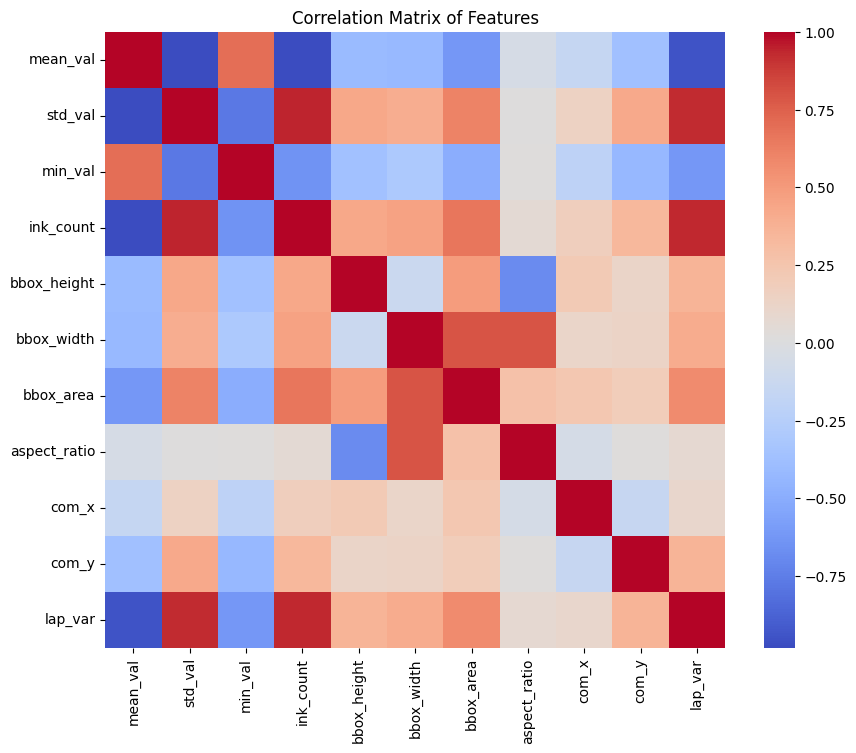

In [7]:
corr = df.drop(columns = ["label"]).corr()

plt.figure(figsize = (10, 8))
sns.heatmap(corr, cmap = "coolwarm", annot = False)
plt.title("Correlation Matrix of Features", fontsize = 12)
plt.show()

### Density Plots

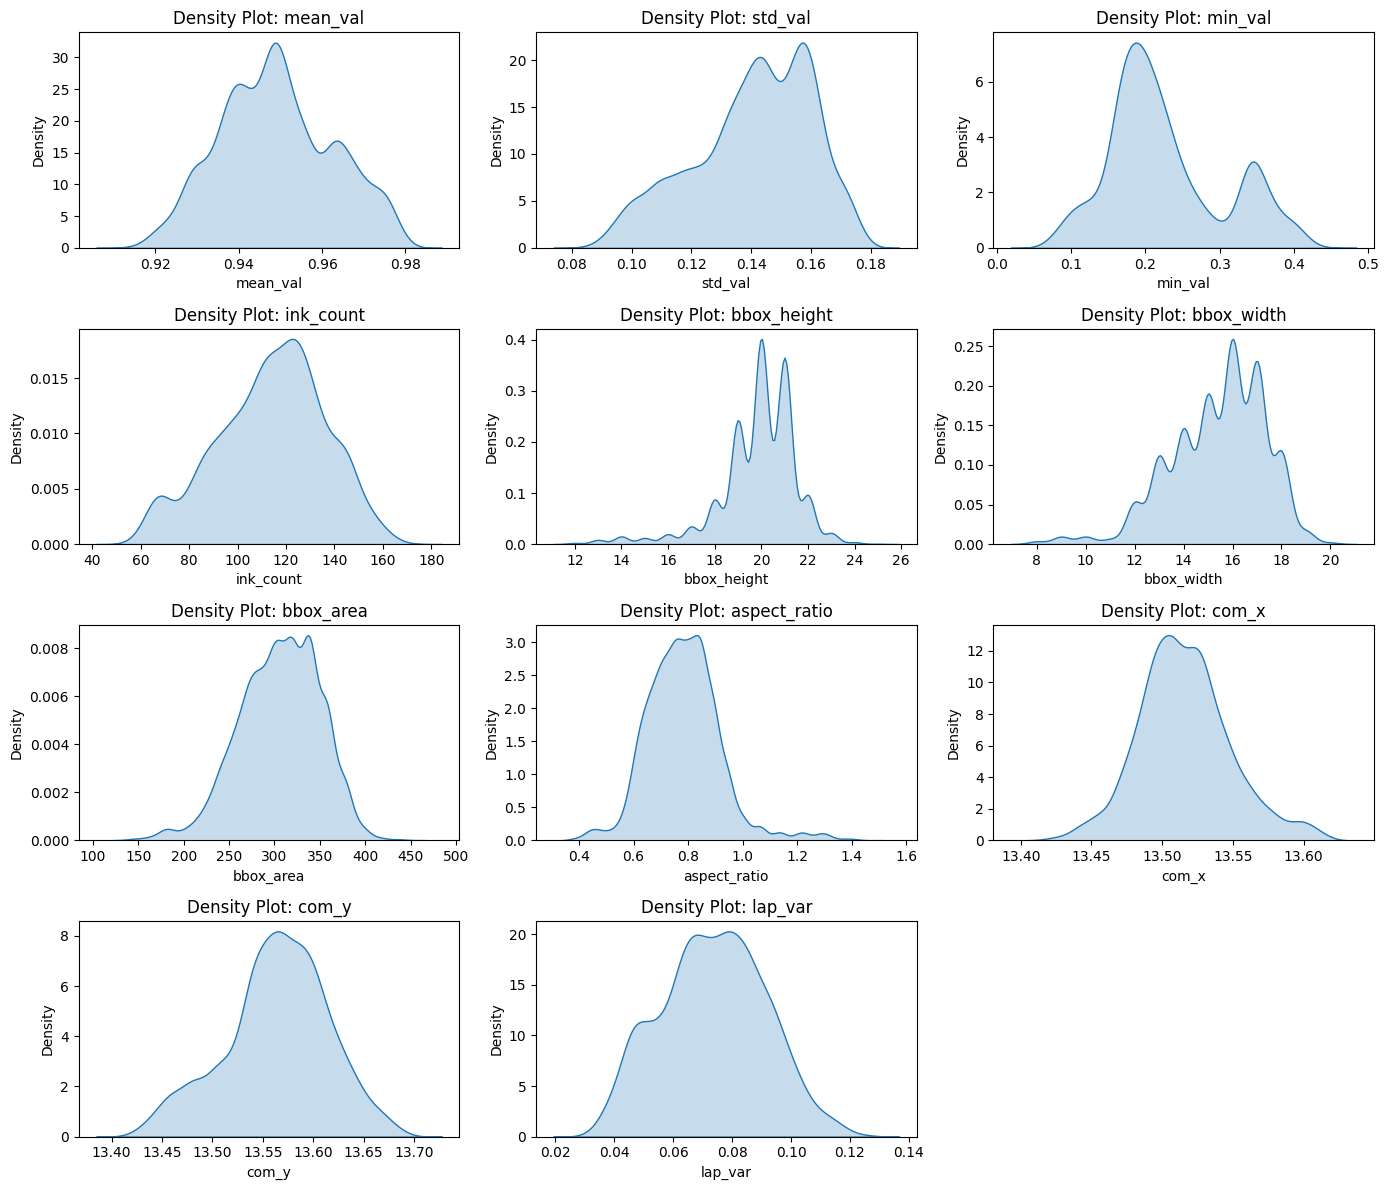

In [8]:
plt.figure(figsize = (14, 12))
for i, feat in enumerate(feature_columns):
    plt.subplot(4, 3, i + 1)
    sns.kdeplot(df[feat], fill = True)
    plt.title(f"Density Plot: {feat}")

plt.tight_layout()
plt.show()

### Mean Feature Values Bar Graphs

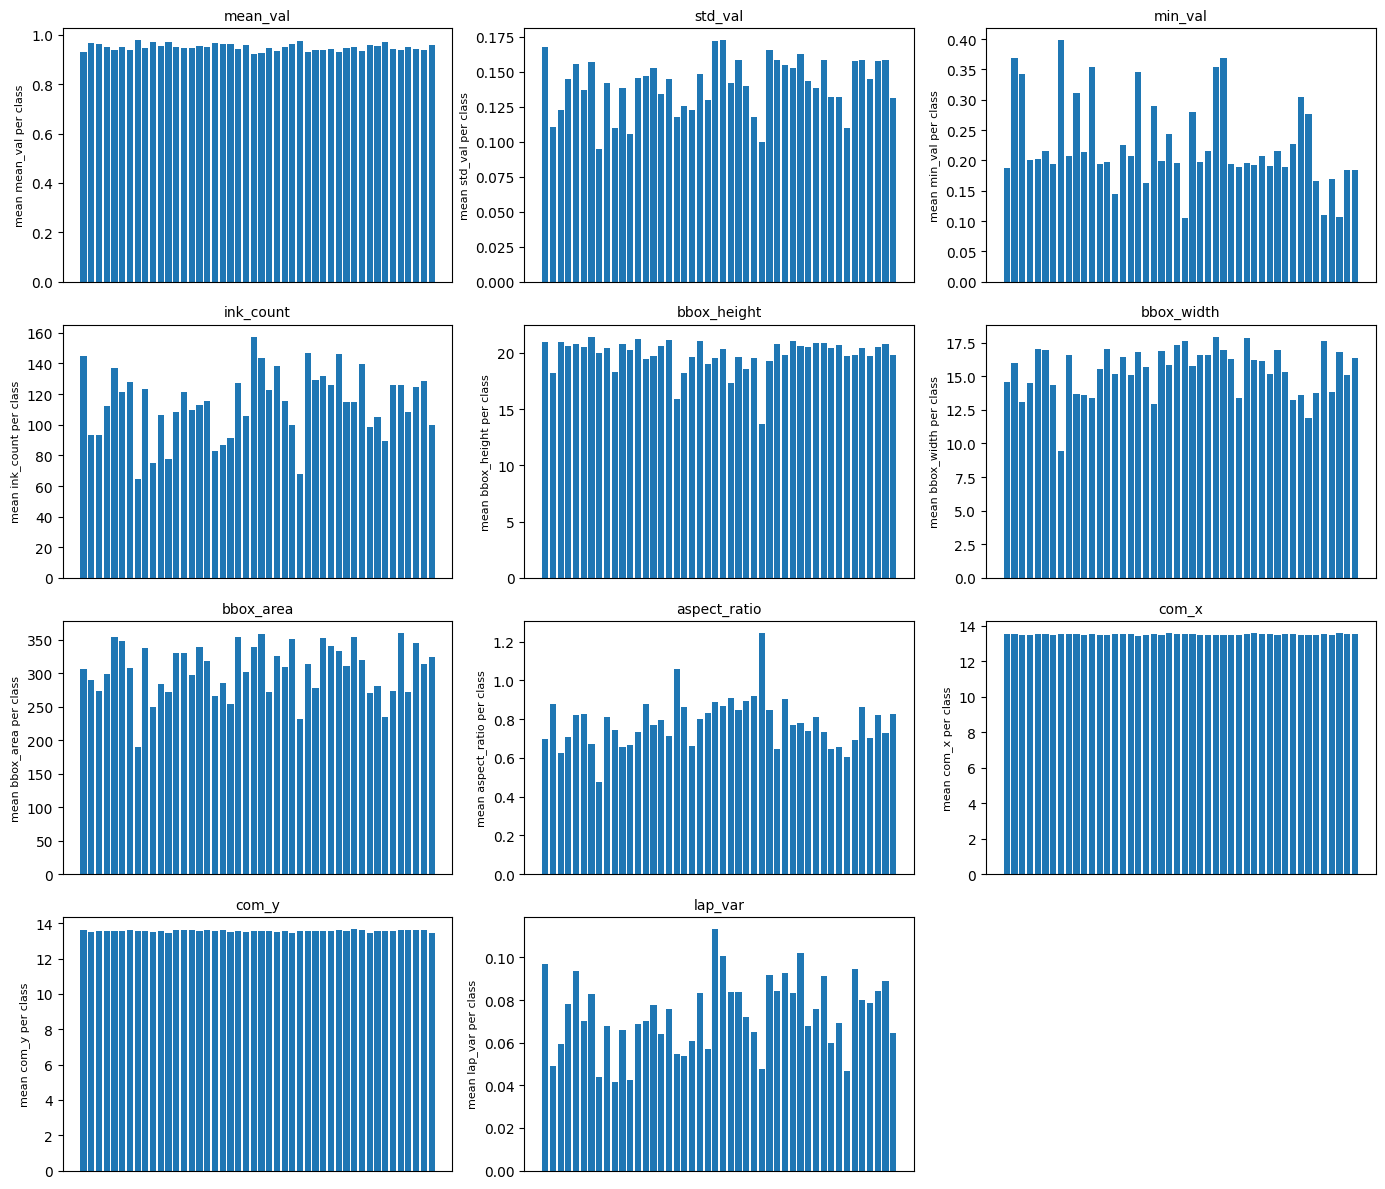

In [9]:
plt.figure(figsize = (14, 12))
for i, feat in enumerate(feature_columns):
    plt.subplot(4, 3, i + 1)

    mean_per_class = df.groupby("label")[feat].mean()
    plt.bar(range(len(mean_per_class)), mean_per_class)

    plt.title(feat, fontsize = 10)
    plt.xticks([])
    plt.ylabel(f"mean {feat} per class", fontsize = 8)

plt.tight_layout()
plt.show()

### Sample Images

In [10]:
def load_processed_image(path, target_size = (28, 28)):
    img = imread(path)
    if img.ndim == 3:
        img = rgb2gray(img)
    img = resize(img, target_size, anti_aliasing = True)
    return img

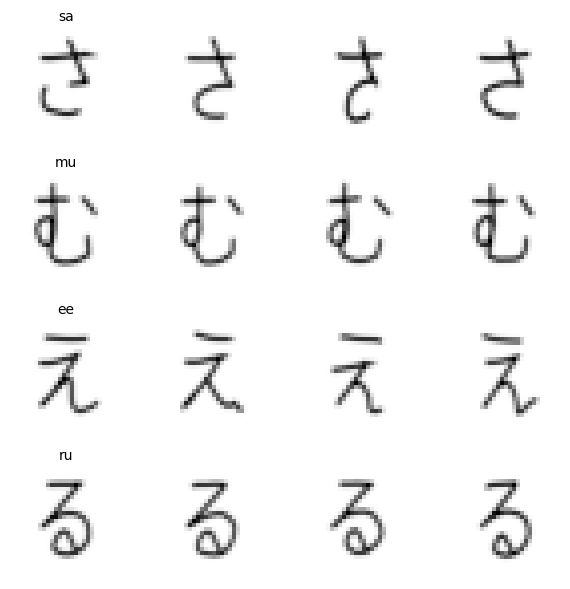

In [11]:
paths_by_class = {}
for p in image_paths:
    if p.parent.name not in paths_by_class:
        paths_by_class[p.parent.name] = []
    paths_by_class[p.parent.name].append(p)

classes_to_show = ["sa", "mu", "ee", "ru"]

fig, axes = plt.subplots(len(classes_to_show), 4, figsize = (6, 6))

for row, character_class in enumerate(classes_to_show):
    sample_paths = random.sample(paths_by_class[character_class], 4)
    for col, img_path in enumerate(sample_paths):
        ax = axes[row, col]
        character_image = load_processed_image(img_path)
        ax.imshow(character_image, cmap = "gray")
        ax.axis("off")
        if col == 0:
            ax.set_title(f"{character_class}", fontsize = 10)

plt.tight_layout()
plt.show()

## Splitting the dataset

In this section, I split the dataset into:
- 70% training data
- 15% validation data (for hyperparameter tuning)
- 15% test data (for final evaluation)

In [12]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, 
    y, 
    test_size = 0.30, 
    random_state = 42, 
    stratify = y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, 
    y_temp, 
    test_size = 0.50, 
    random_state = 42, 
    stratify = y_temp
)

## Feature Scaling and Transformations

In this section, I scale my data as part of preprocessing. I fit the scaler only on the training set, then apply the same scaling parameters to the validation set and test set. I also transform my features for future model training with feature transformation. Feature transformations include:
- Polynomial Degree 2
- Polynomial Degree 3
- K-Means Clustering

In [13]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Polynomial Degree 2
poly_degree_two = PolynomialFeatures(degree = 2, include_bias = False)
X_train_poly_degree_two = poly_degree_two.fit_transform(X_train_scaled)
X_val_poly_degree_two = poly_degree_two.transform(X_val_scaled)
X_test_poly_degree_two = poly_degree_two.transform(X_test_scaled)

# Polynomial Degree 3
poly_degree_three = PolynomialFeatures(degree = 3, include_bias = False)
X_train_poly_degree_three = poly_degree_three.fit_transform(X_train_scaled)
X_val_poly_degree_three = poly_degree_three.transform(X_val_scaled)
X_test_poly_degree_three = poly_degree_three.transform(X_test_scaled)

# K-Means Clustering
kmeans = KMeans(n_clusters = 8, random_state = 42)
kmeans.fit(X_train_scaled)
X_train_kmeans = np.hstack([X_train_scaled, kmeans.transform(X_train_scaled)])
X_val_kmeans = np.hstack([X_val_scaled, kmeans.transform(X_val_scaled)])
X_test_kmeans = np.hstack([X_test_scaled, kmeans.transform(X_test_scaled)])

## Dataset Shape Verification

Before training any models, I verify that the feature matrices and label arrays have the correct shapes after splitting and scaling. Each feature vector should have 22 features.

In [14]:
print("---- SCALED DATA ----")
print("X_train_scaled: ", X_train_scaled.shape)
print("X_val_scaled: ", X_val_scaled.shape)
print("X_test_scaled: ", X_test_scaled.shape)

print("---- POLYNOMIAL FEATURES DEGREE 2 ----")
print("X_train_poly_degree_two: ", X_train_poly_degree_two.shape)
print("X_val_poly_degree_two: ", X_val_poly_degree_two.shape)
print("X_test_poly_degree_two: ", X_test_poly_degree_two.shape)

print("---- POLYNOMIAL FEATURES DEGREE 3 ----")
print("X_train_poly_degree_three: ", X_train_poly_degree_three.shape)
print("X_val_poly_degree_three: ", X_val_poly_degree_three.shape)
print("X_test_poly_degree_three: ", X_test_poly_degree_three.shape)

print("---- K-MEANS TRANSFORMED FEATURES ----")
print("X_train_kmeans:", X_train_kmeans.shape)
print("X_val_kmeans: ", X_val_kmeans.shape)
print("X_test_kmeans: ", X_test_kmeans.shape)

print("---- y ----")
print("y_train: ", y_train.shape)
print("y_val: ", y_val.shape)
print("y_test: ", y_test.shape)

---- SCALED DATA ----
X_train_scaled:  (3220, 11)
X_val_scaled:  (690, 11)
X_test_scaled:  (690, 11)
---- POLYNOMIAL FEATURES DEGREE 2 ----
X_train_poly_degree_two:  (3220, 77)
X_val_poly_degree_two:  (690, 77)
X_test_poly_degree_two:  (690, 77)
---- POLYNOMIAL FEATURES DEGREE 3 ----
X_train_poly_degree_three:  (3220, 363)
X_val_poly_degree_three:  (690, 363)
X_test_poly_degree_three:  (690, 363)
---- K-MEANS TRANSFORMED FEATURES ----
X_train_kmeans: (3220, 19)
X_val_kmeans:  (690, 19)
X_test_kmeans:  (690, 19)
---- y ----
y_train:  (3220,)
y_val:  (690,)
y_test:  (690,)


## LOGISTIC REGRESSION
### Baseline Logistic Refression

In this section, I run the baseline Logistic Regression model to find the starting metrics for the validation set before applying L2 Regularization with varying C values as hyperparameter tuning.

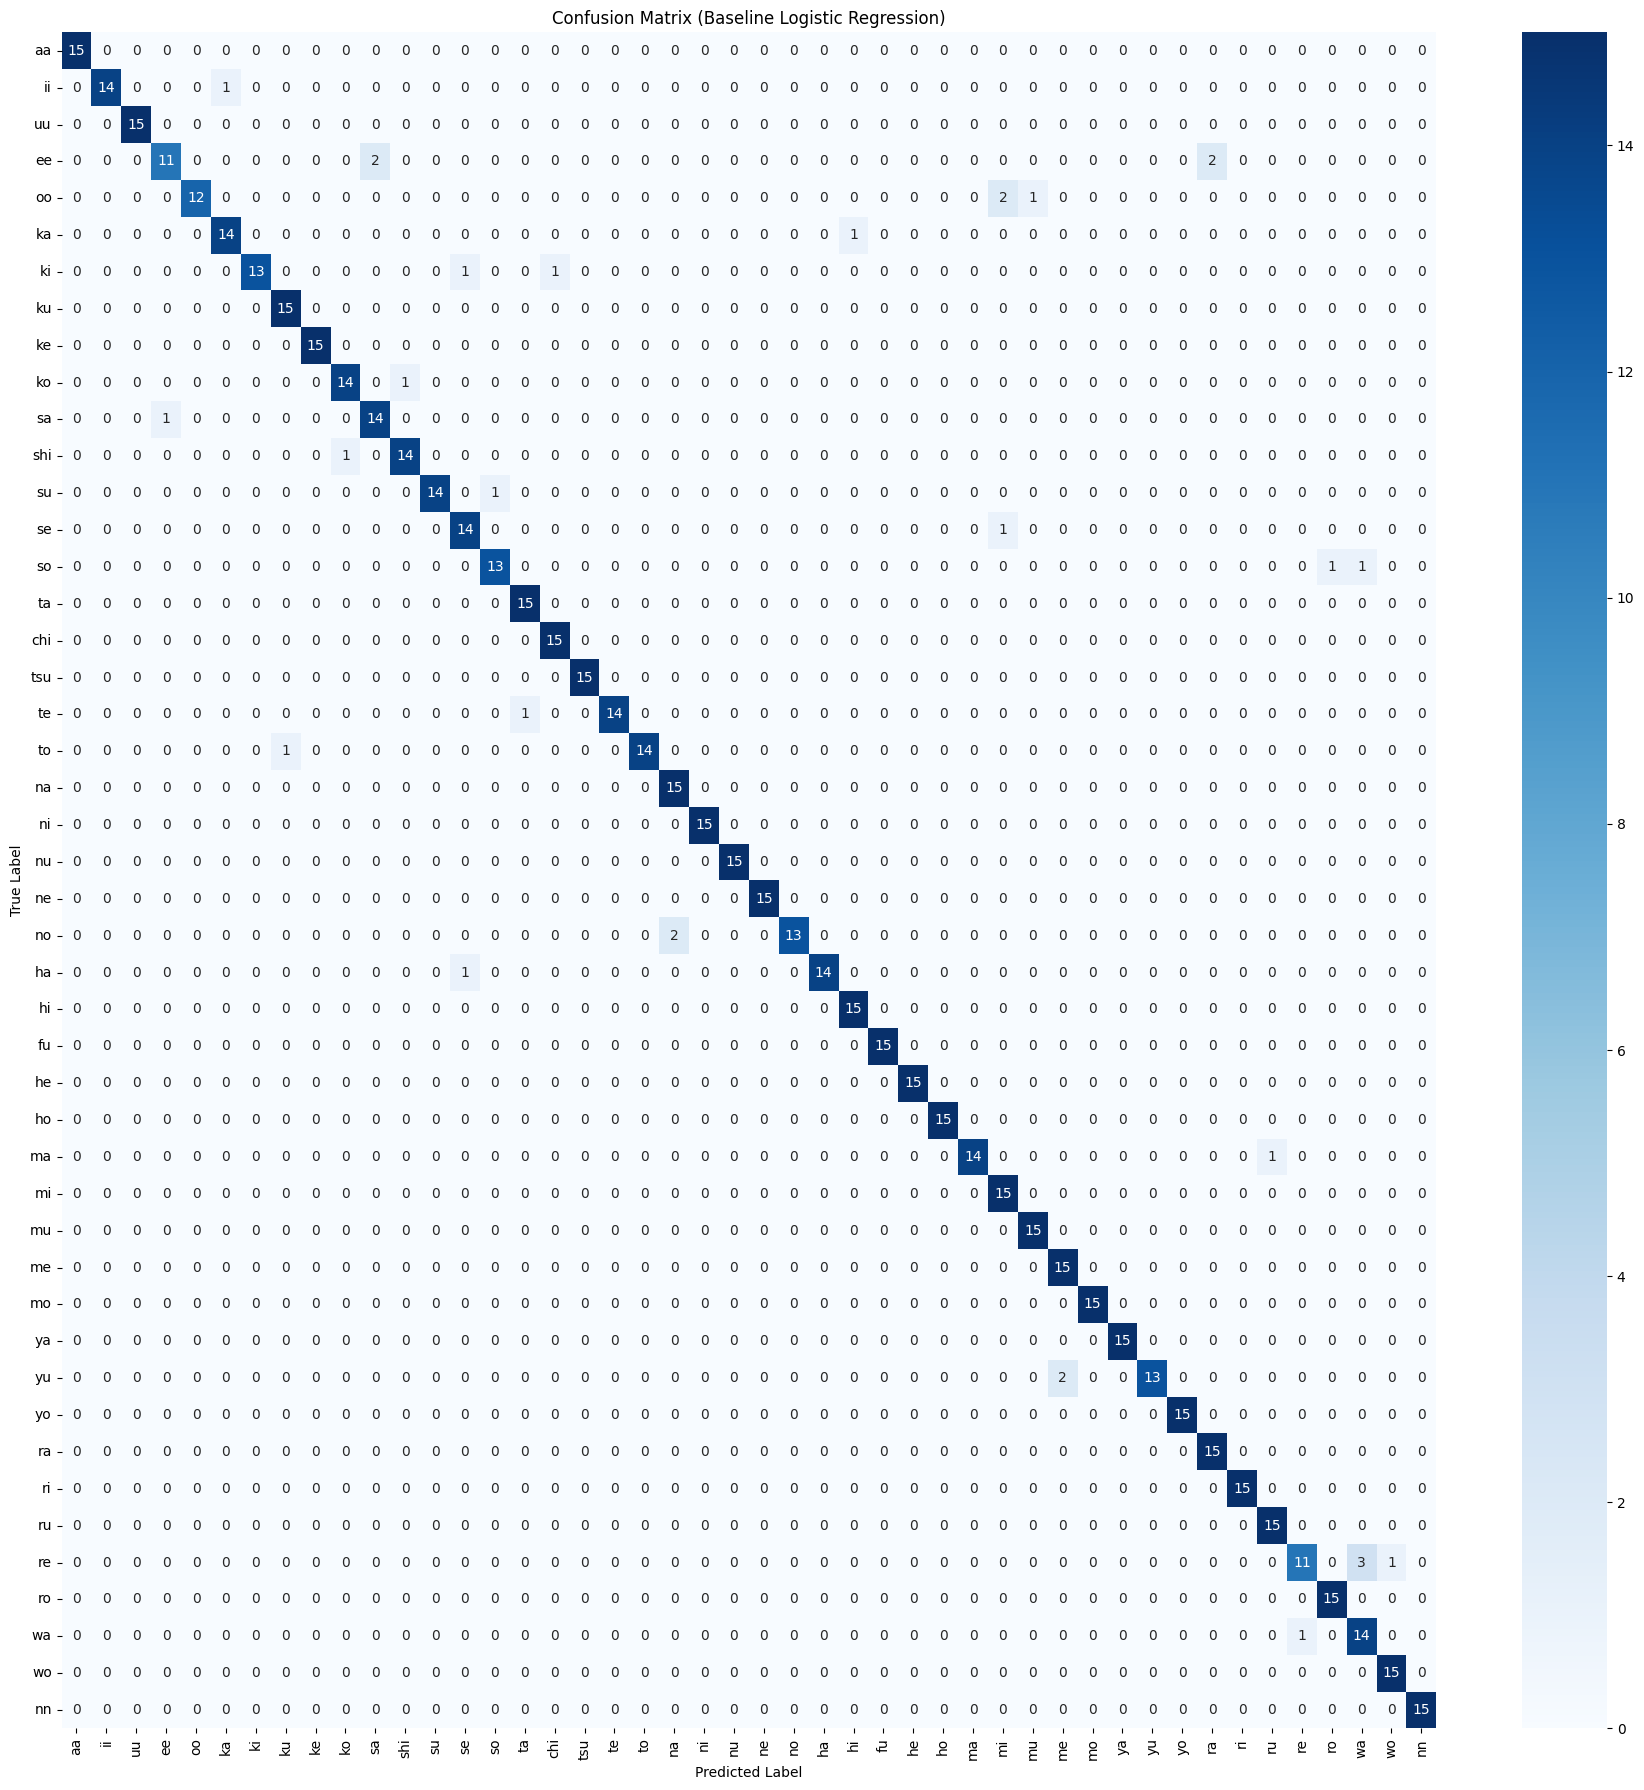

---- Baseline Performance (Logistic Regression) ----
Train Accuracy: 0.9792
Validation Accuracy: 0.9551
Validation Precision: 0.9580
Validation Recall: 0.9551
Validation F1 Score: 0.9546


In [15]:
baseline_lr = LogisticRegression(
    penalty = None,
    solver = "lbfgs",
    max_iter = 1000
)

baseline_lr.fit(X_train_scaled, y_train)

y_hat_train_baseline_lr = baseline_lr.predict(X_train_scaled)
y_hat_val_baseline_lr = baseline_lr.predict(X_val_scaled)

baseline_lr_train_accuracy = accuracy_score(y_train, y_hat_train_baseline_lr)
baseline_lr_val_accuracy = accuracy_score(y_val, y_hat_val_baseline_lr)
baseline_lr_val_precision = precision_score(y_val, y_hat_val_baseline_lr, average = 'macro', zero_division = 0)
baseline_lr_val_recall = recall_score(y_val, y_hat_val_baseline_lr, average = 'macro', zero_division = 0)
baseline_lr_val_f1 = f1_score(y_val, y_hat_val_baseline_lr, average = 'macro', zero_division = 0)
baseline_lr_val_cm = confusion_matrix(y_val, y_hat_val_baseline_lr)

plt.figure(figsize = (18, 18))
sns.heatmap(
    baseline_lr_val_cm,
    annot = True,
    cmap = "Blues",
    xticklabels = PHONETIC_LABELS,
    yticklabels = PHONETIC_LABELS
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Baseline Logistic Regression)")
plt.xticks(rotation = 90, fontsize = 10)
plt.yticks(rotation = 0, fontsize = 10)
plt.tight_layout()
plt.show()

print("---- Baseline Performance (Logistic Regression) ----")
print(f"Train Accuracy: {baseline_lr_train_accuracy:.4f}")
print(f"Validation Accuracy: {baseline_lr_val_accuracy:.4f}")
print(f"Validation Precision: {baseline_lr_val_precision:.4f}")
print(f"Validation Recall: {baseline_lr_val_recall:.4f}")
print(f"Validation F1 Score: {baseline_lr_val_f1:.4f}")

### No Feature Transformation with Hyperparameter Tuning

In this section, I train a multinomial Logistic Regression model with no feature transformation and L2 Regularization with varying C values, seeing how each hyperparameter tuning affects validation metrics.

In [18]:
logreg_results = []
C_values = [1000000, 1.0, 0.1, 0.01, 0.001, 0.0001]

In [19]:
def plot_logreg_metric_vs_C(df, metric, transformation_name):
    plt.figure(figsize = (6, 4))

    subset = df[df["transformation"] == transformation_name].copy()
    subset = subset.sort_values(by = "C")
    
    Cs = subset["C"].values
    ys = subset[metric].values
    
    plt.plot(
        Cs,
        ys,
        marker = "o",
        label = transformation_name
    )
    
    plt.xscale("log")
    plt.xlabel("C (log scale)")
    plt.ylabel(metric.replace("val_", "").replace("_", " ").title())
    plt.title(f"Logistic Regression: {metric.replace('val_', '').upper()} vs C")
    plt.grid(True, alpha=0.3)
    plt.legend(title = "Transformation", fontsize=8)
    plt.tight_layout()
    plt.show()

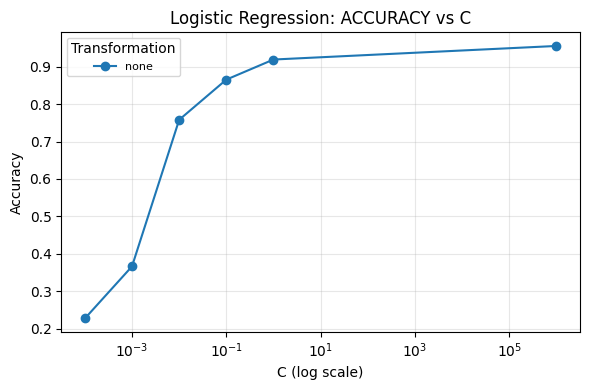

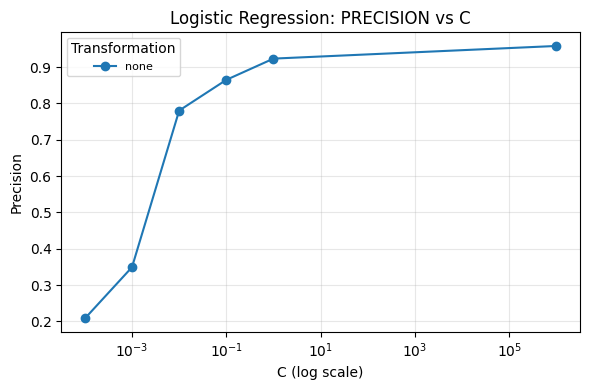

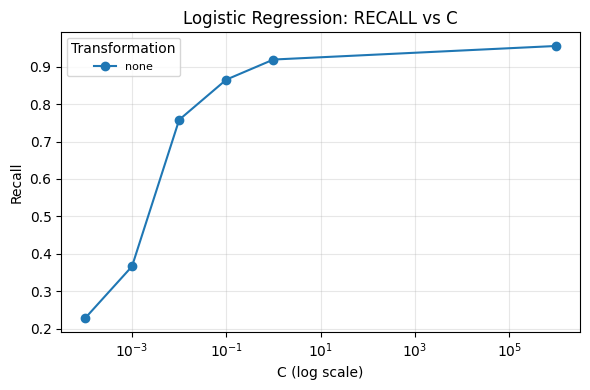

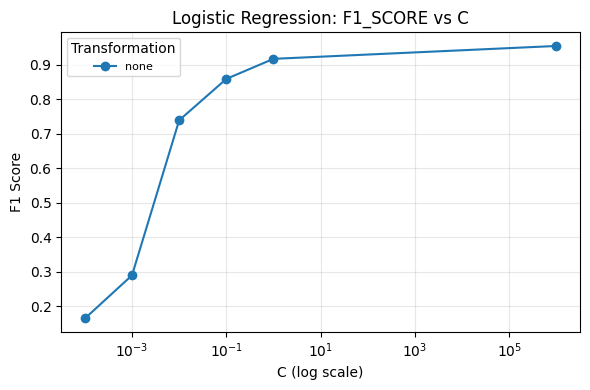

,transformation,C,train_accuracy,val_accuracy,val_precision,val_recall,val_f1_score
0,none,1000000.0000,0.980124,0.955072,0.958045,0.955072,0.954616
1,none,1.0000,0.926708,0.918841,0.923226,0.918841,0.917269
2,none,0.1000,0.874534,0.865217,0.864772,0.865217,0.859132
3,none,0.0100,0.769565,0.757971,0.780226,0.757971,0.739163
4,none,0.0010,0.378261,0.366667,0.349217,0.366667,0.289839
5,none,0.0001,0.227640,0.227536,0.207941,0.227536,0.164634


In [20]:
for C in C_values:
    model = LogisticRegression(
        penalty = "l2",
        solver = "lbfgs",
        C = C,
        max_iter = 1000
    )

    model.fit(X_train_scaled, y_train)
    y_train_pred = model.predict(X_train_scaled)
    y_val_pred = model.predict(X_val_scaled)

    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc = accuracy_score(y_val, y_val_pred)
    val_prec = precision_score(y_val, y_val_pred, average = "macro", zero_division = 0)
    val_rec = recall_score(y_val, y_val_pred, average = "macro", zero_division = 0)
    val_f1 = f1_score(y_val, y_val_pred, average = "macro", zero_division = 0)

    logreg_results.append({
        "transformation": "none",
        "C": C,
        "train_accuracy": train_acc,
        "val_accuracy": val_acc,
        "val_precision": val_prec,
        "val_recall": val_rec,
        "val_f1_score": val_f1
    })

logreg_df = pd.DataFrame(logreg_results)
plot_logreg_metric_vs_C(logreg_df, "val_accuracy", "none")
plot_logreg_metric_vs_C(logreg_df, "val_precision", "none")
plot_logreg_metric_vs_C(logreg_df, "val_recall", "none")
plot_logreg_metric_vs_C(logreg_df, "val_f1_score", "none")
logreg_df

### Feature Transformaion: Polynomial Degree-2 with Hyperparameter Tuning

In this section, I train a multinomial Logistic Regression model with polynomial degree 2 feature transformation and L2 Regularization with varying C values, seeing how each hyperparameter tuning affects validation metrics.

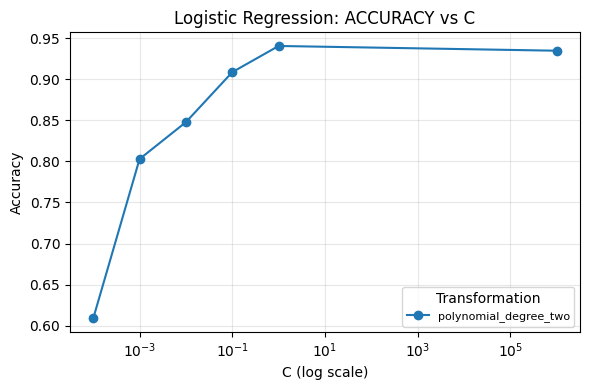

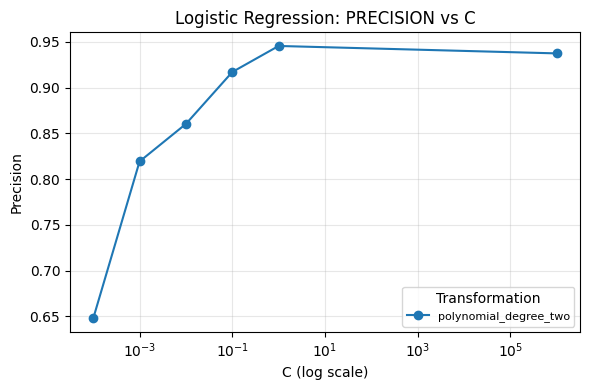

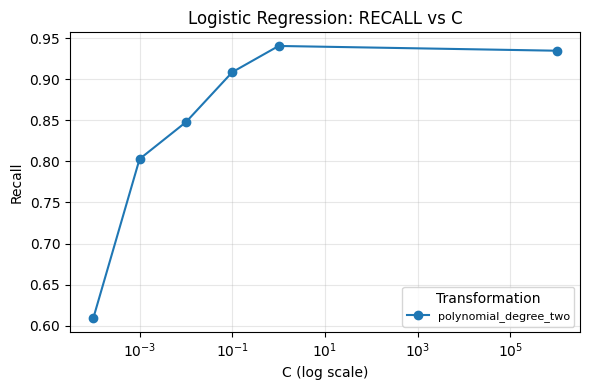

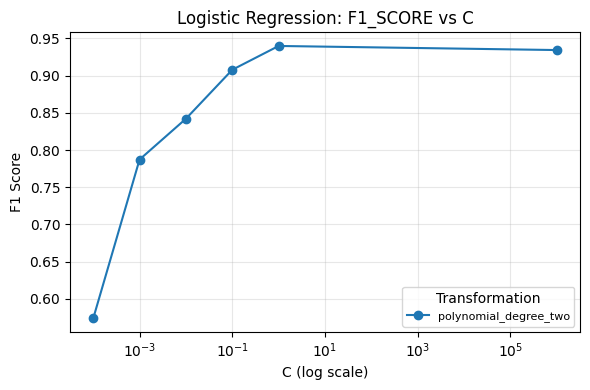

,transformation,C,train_accuracy,val_accuracy,val_precision,val_recall,val_f1_score
6,polynomial_degree_two,1000000.0000,0.999379,0.934783,0.937291,0.934783,0.934437
7,polynomial_degree_two,1.0000,0.964907,0.940580,0.945412,0.940580,0.939949
8,polynomial_degree_two,0.1000,0.926708,0.908696,0.916955,0.908696,0.907937
9,polynomial_degree_two,0.0100,0.868634,0.847826,0.860262,0.847826,0.842087
10,polynomial_degree_two,0.0010,0.804658,0.802899,0.819240,0.802899,0.787210
11,polynomial_degree_two,0.0001,0.637578,0.608696,0.647703,0.608696,0.573405


In [22]:
for C in C_values:
    model = LogisticRegression(
        penalty = "l2",
        solver = "lbfgs",
        C = C,
        max_iter = 1000
    )

    model.fit(X_train_poly_degree_two, y_train)
    y_train_pred = model.predict(X_train_poly_degree_two)
    y_val_pred   = model.predict(X_val_poly_degree_two)

    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc = accuracy_score(y_val, y_val_pred)
    val_prec = precision_score(y_val, y_val_pred, average = "macro", zero_division = 0)
    val_rec = recall_score(y_val, y_val_pred, average = "macro", zero_division = 0)
    val_f1 = f1_score(y_val, y_val_pred, average = "macro", zero_division = 0)

    logreg_results.append({
        "transformation": "polynomial_degree_two",
        "C": C,
        "train_accuracy": train_acc,
        "val_accuracy": val_acc,
        "val_precision": val_prec,
        "val_recall": val_rec,
        "val_f1_score": val_f1
    })

logreg_df = pd.DataFrame(logreg_results)
polynomial_degree_two_df = logreg_df[logreg_df["transformation"] == "polynomial_degree_two"].copy()
plot_logreg_metric_vs_C(polynomial_degree_two_df, "val_accuracy", "polynomial_degree_two")
plot_logreg_metric_vs_C(polynomial_degree_two_df, "val_precision", "polynomial_degree_two")
plot_logreg_metric_vs_C(polynomial_degree_two_df, "val_recall", "polynomial_degree_two")
plot_logreg_metric_vs_C(polynomial_degree_two_df, "val_f1_score", "polynomial_degree_two")
polynomial_degree_two_df

### Feature Transformaion: Polynomial Degree-3 with Hyperparameter Tuning

In this section, I train a multinomial Logistic Regression model with polynomial degree 3 feature transformation and L2 Regularization with varying C values, seeing how each hyperparameter tuning affects validation metrics.

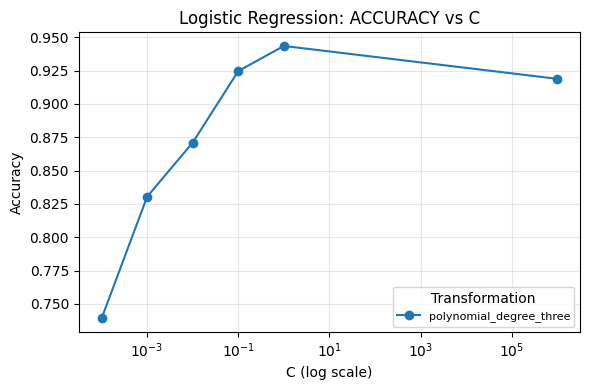

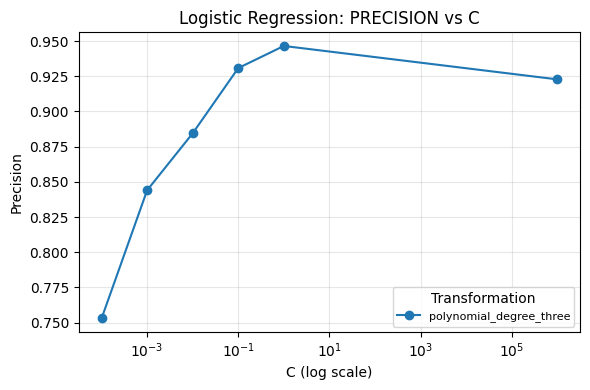

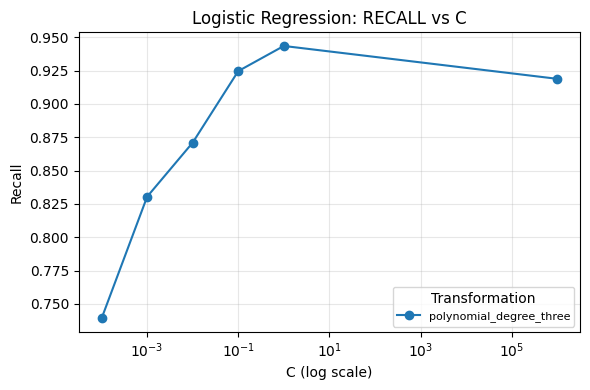

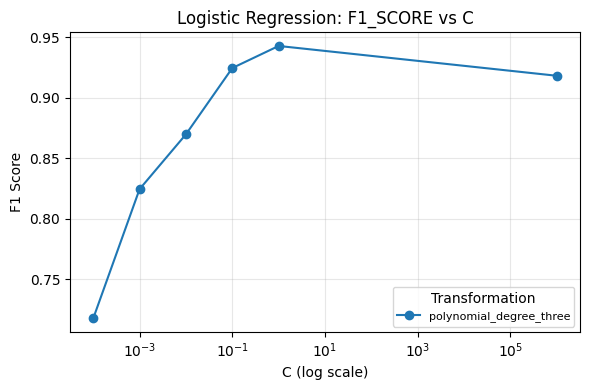

,transformation,C,train_accuracy,val_accuracy,val_precision,val_recall,val_f1_score
12,polynomial_degree_three,1000000.0000,1.000000,0.918841,0.922812,0.918841,0.918230
13,polynomial_degree_three,1.0000,0.986335,0.943478,0.946543,0.943478,0.942893
14,polynomial_degree_three,0.1000,0.954969,0.924638,0.930821,0.924638,0.924619
15,polynomial_degree_three,0.0100,0.896273,0.871014,0.884496,0.871014,0.869773
16,polynomial_degree_three,0.0010,0.850621,0.830435,0.844011,0.830435,0.824409
17,polynomial_degree_three,0.0001,0.759317,0.739130,0.752908,0.739130,0.717370


In [23]:
for C in C_values:
    model = LogisticRegression(
        penalty = "l2",
        solver = "lbfgs",
        C = C,
        max_iter = 1000
    )

    model.fit(X_train_poly_degree_three, y_train)
    y_train_pred = model.predict(X_train_poly_degree_three)
    y_val_pred   = model.predict(X_val_poly_degree_three)

    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc = accuracy_score(y_val, y_val_pred)
    val_prec = precision_score(y_val, y_val_pred, average = "macro", zero_division = 0)
    val_rec = recall_score(y_val, y_val_pred, average = "macro", zero_division = 0)
    val_f1 = f1_score(y_val, y_val_pred, average = "macro", zero_division = 0)

    logreg_results.append({
        "transformation": "polynomial_degree_three",
        "C": C,
        "train_accuracy": train_acc,
        "val_accuracy": val_acc,
        "val_precision": val_prec,
        "val_recall": val_rec,
        "val_f1_score": val_f1
    })

logreg_df = pd.DataFrame(logreg_results)
polynomial_degree_three_df = logreg_df[logreg_df["transformation"] == "polynomial_degree_three"].copy()
plot_logreg_metric_vs_C(polynomial_degree_three_df, "val_accuracy", "polynomial_degree_three")
plot_logreg_metric_vs_C(polynomial_degree_three_df, "val_precision", "polynomial_degree_three")
plot_logreg_metric_vs_C(polynomial_degree_three_df, "val_recall", "polynomial_degree_three")
plot_logreg_metric_vs_C(polynomial_degree_three_df, "val_f1_score", "polynomial_degree_three")
polynomial_degree_three_df

### Feature Transformation: K-Means Cluster with Hyperparameter Tuning

In this section, I train a multinomial Logistic Regression model with k-means clusters feature transformation and L2 Regularization with varying C values, seeing how each hyperparameter tuning affects validation metrics.

/Users/sam/Desktop/hiragana-ml-project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


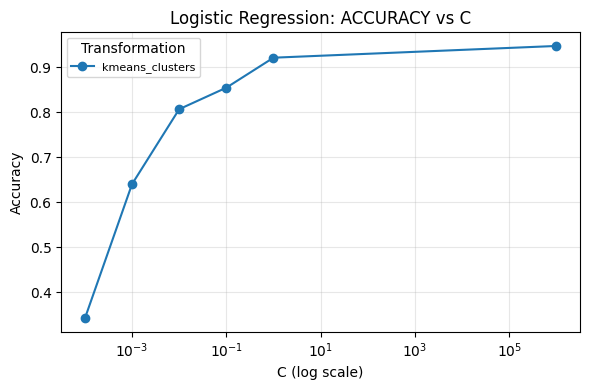

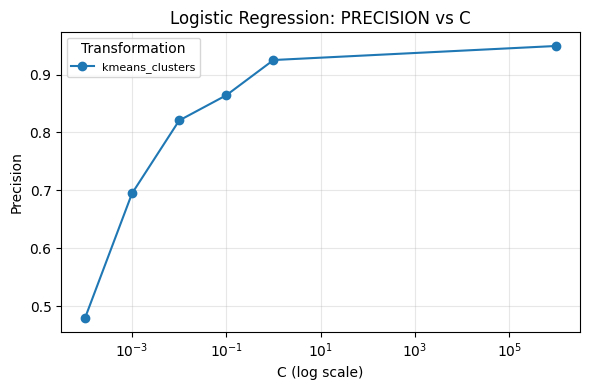

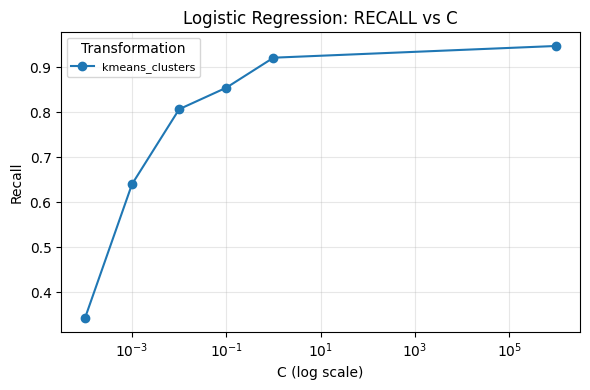

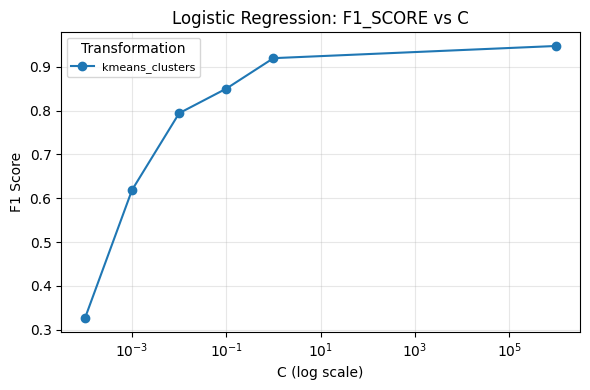

,transformation,C,train_accuracy,val_accuracy,val_precision,val_recall,val_f1_score
18,kmeans_clusters,1000000.0000,0.989130,0.947826,0.949213,0.947826,0.947447
19,kmeans_clusters,1.0000,0.932609,0.921739,0.924966,0.921739,0.919641
20,kmeans_clusters,0.1000,0.875466,0.855072,0.864230,0.855072,0.850169
21,kmeans_clusters,0.0100,0.811801,0.807246,0.820718,0.807246,0.794112
22,kmeans_clusters,0.0010,0.662422,0.640580,0.694914,0.640580,0.618856
23,kmeans_clusters,0.0001,0.336025,0.342029,0.479296,0.342029,0.325889


In [24]:
for C in C_values:
    model = LogisticRegression(
        penalty = "l2",
        solver = "lbfgs",
        C = C,
        max_iter = 1000
    )

    model.fit(X_train_kmeans, y_train)

    y_train_pred = model.predict(X_train_kmeans)
    y_val_pred = model.predict(X_val_kmeans)

    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc = accuracy_score(y_val, y_val_pred)
    val_prec = precision_score(y_val, y_val_pred, average = "macro", zero_division = 0)
    val_rec = recall_score(y_val, y_val_pred, average = "macro", zero_division = 0)
    val_f1 = f1_score(y_val, y_val_pred, average = "macro", zero_division = 0)

    logreg_results.append({
        "transformation": "kmeans_clusters",
        "C": C,
        "train_accuracy": train_acc,
        "val_accuracy": val_acc,
        "val_precision": val_prec,
        "val_recall": val_rec,
        "val_f1_score": val_f1
    })

logreg_df = pd.DataFrame(logreg_results)
kmeans_clusters_df = logreg_df[logreg_df["transformation"] == "kmeans_clusters"].copy()
plot_logreg_metric_vs_C(kmeans_clusters_df, "val_accuracy", "kmeans_clusters")
plot_logreg_metric_vs_C(kmeans_clusters_df, "val_precision", "kmeans_clusters")
plot_logreg_metric_vs_C(kmeans_clusters_df, "val_recall", "kmeans_clusters")
plot_logreg_metric_vs_C(kmeans_clusters_df, "val_f1_score", "kmeans_clusters")
kmeans_clusters_df

## K-NEAREST NEIGHBORS
### Baseline KNN

In this section, I run the baseline KNN model to find the starting metrics for the validation set before using different k values for neighbors and weights value as hyperparameter tuning.

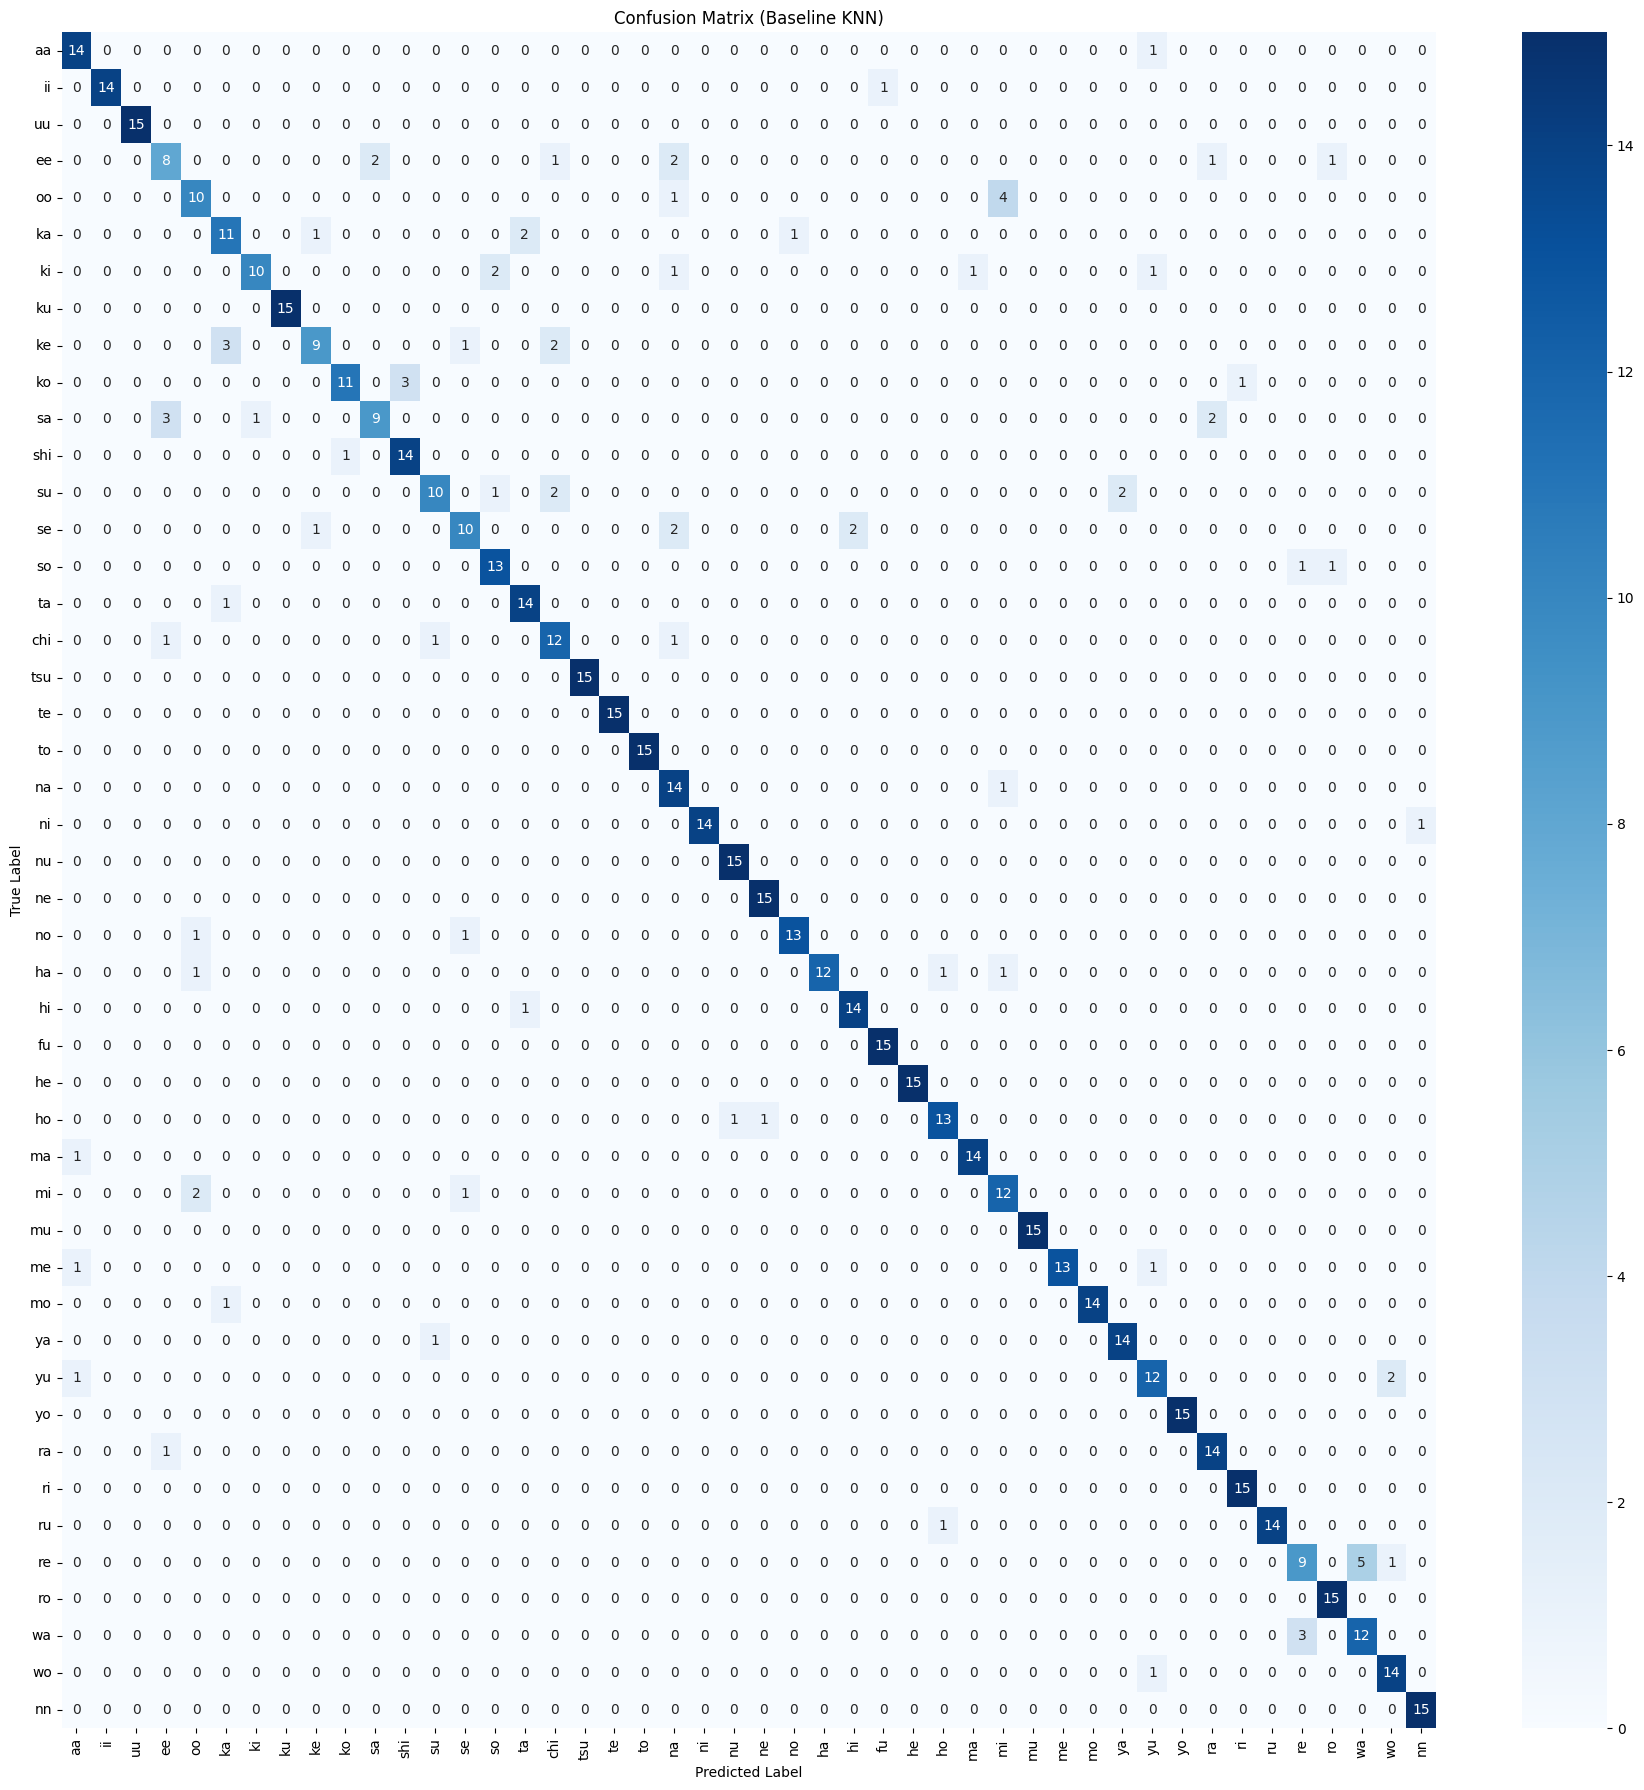

---- Baseline Performance (KNN) ----
Train Accuracy: 0.9245
Validation Accuracy: 0.8710
Validation Precision: 0.8750
Validation Recall: 0.8710
Validation F1 Score: 0.8693


In [27]:
baseline_knn = KNeighborsClassifier(
    n_neighbors = 5,
    weights = 'uniform'   
)

baseline_knn.fit(X_train_scaled, y_train)

y_hat_train_baseline_knn = baseline_knn.predict(X_train_scaled)
y_hat_val_baseline_knn = baseline_knn.predict(X_val_scaled)

baseline_knn_train_accuracy = accuracy_score(y_train, y_hat_train_baseline_knn)
baseline_knn_val_accuracy = accuracy_score(y_val, y_hat_val_baseline_knn)
baseline_knn_val_precision = precision_score(y_val, y_hat_val_baseline_knn, average = 'macro', zero_division = 0)
baseline_knn_val_recall = recall_score(y_val, y_hat_val_baseline_knn, average = 'macro', zero_division = 0)
baseline_knn_val_f1 = f1_score(y_val, y_hat_val_baseline_knn, average = 'macro', zero_division = 0)
baseline_knn_val_cm = confusion_matrix(y_val, y_hat_val_baseline_knn)

plt.figure(figsize = (18, 18))
sns.heatmap(
    baseline_knn_val_cm,
    annot = True,
    cmap = "Blues",
    xticklabels = PHONETIC_LABELS,
    yticklabels = PHONETIC_LABELS
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Baseline KNN)")
plt.xticks(rotation = 90, fontsize = 10)
plt.yticks(rotation = 0, fontsize = 10)
plt.tight_layout()
plt.show()

print("---- Baseline Performance (KNN) ----")
print(f"Train Accuracy: {baseline_knn_train_accuracy:.4f}")
print(f"Validation Accuracy: {baseline_knn_val_accuracy:.4f}")
print(f"Validation Precision: {baseline_knn_val_precision:.4f}")
print(f"Validation Recall: {baseline_knn_val_recall:.4f}")
print(f"Validation F1 Score: {baseline_knn_val_f1:.4f}")

## K-NEAREST NEIGHBORS
### No Feature Transformation with Hyperparameter Tuning

In this section, I train a KNN model with no feature transformation and varying k values with uniform and distance weight types, seeing how each hyperparameter tuning affects validation metrics.

In [28]:
knn_results = []
k_values = [1, 5, 10]
weights = ["uniform", "distance"]

In [29]:
def plot_knn_metric_vs_k(df, metric, transformation_name):
    subset = df[df["transformation"] == transformation_name].copy()
    weight_types = subset["weights"].unique()
    
    plt.figure(figsize=(6, 4))
    
    for w in weight_types:
        sub = subset[subset["weights"] == w].sort_values(by="k")

        ks = sub["k"].values
        ys = sub[metric].values

        plt.plot(
            ks,
            ys,
            marker="o",
            label=f"{transformation_name} ({w})"
        )
    
    plt.xlabel("k (number of neighbors)")
    plt.ylabel(metric.replace("val_", "").replace("_", " ").title())
    plt.title(f"KNN: {metric.replace('val_', '').upper()} vs k")
    
    plt.grid(True, alpha=0.3)
    plt.legend(title="Weight Type", fontsize=8)
    plt.tight_layout()
    plt.show()

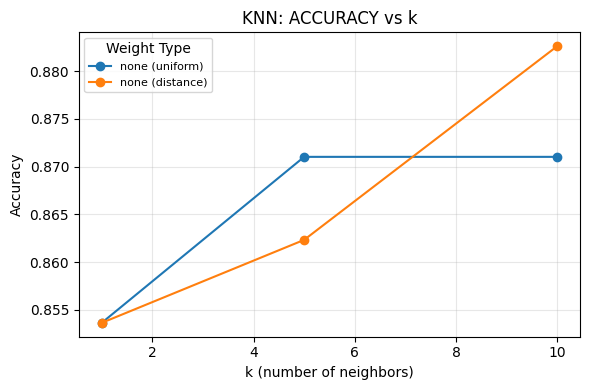

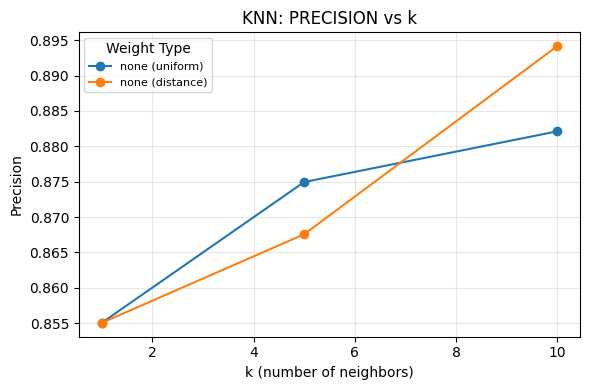

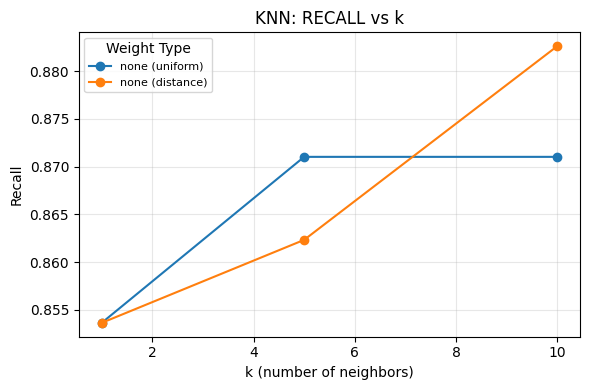

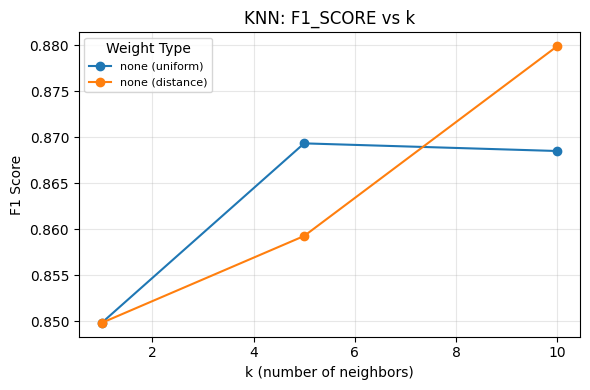

,transformation,weights,k,train_accuracy,val_accuracy,val_precision,val_recall,val_f1_score
0,none,uniform,1,1.000000,0.853623,0.855039,0.853623,0.849797
1,none,uniform,5,0.924534,0.871014,0.874953,0.871014,0.869326
2,none,uniform,10,0.900000,0.871014,0.882125,0.871014,0.868495
3,none,distance,1,1.000000,0.853623,0.855039,0.853623,0.849797
4,none,distance,5,1.000000,0.862319,0.867572,0.862319,0.859252
5,none,distance,10,1.000000,0.882609,0.894165,0.882609,0.879900


In [32]:
for w in weights:
    for k in k_values:
        model = KNeighborsClassifier(
            n_neighbors = k,
            weights = w
        )

        model.fit(X_train_scaled, y_train)

        y_train_pred = model.predict(X_train_scaled)
        y_val_pred = model.predict(X_val_scaled)

        train_accuracy = accuracy_score(y_train, y_train_pred)
        val_accuracy = accuracy_score(y_val, y_val_pred)
        val_precision = precision_score(y_val, y_val_pred, average = "macro", zero_division = 0)
        val_recall = recall_score(y_val, y_val_pred, average = "macro", zero_division = 0)
        val_f1_score = f1_score(y_val, y_val_pred, average = "macro", zero_division = 0)

        knn_results.append({
            "transformation": "none",
            "weights": w,
            "k": k,
            "train_accuracy": train_accuracy,
            "val_accuracy": val_accuracy,
            "val_precision": val_precision,
            "val_recall": val_recall,
            "val_f1_score": val_f1_score,
        })

knn_df = pd.DataFrame(knn_results)
plot_knn_metric_vs_k(knn_df, "val_accuracy", "none")
plot_knn_metric_vs_k(knn_df, "val_precision", "none")
plot_knn_metric_vs_k(knn_df, "val_recall", "none")
plot_knn_metric_vs_k(knn_df, "val_f1_score", "none")
knn_df

### Feature Transformaion: Polynomial Degree-2 with Hyperparameter Tuning

In this section, I train a KNN model with polynomial degree 2 feature transformation and varying k values with uniform and distance weight types, seeing how each hyperparameter tuning affects validation metrics.

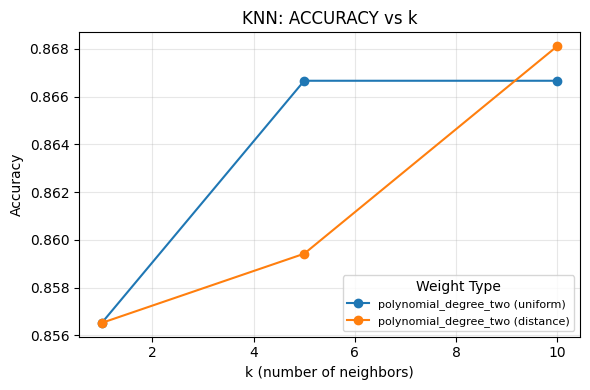

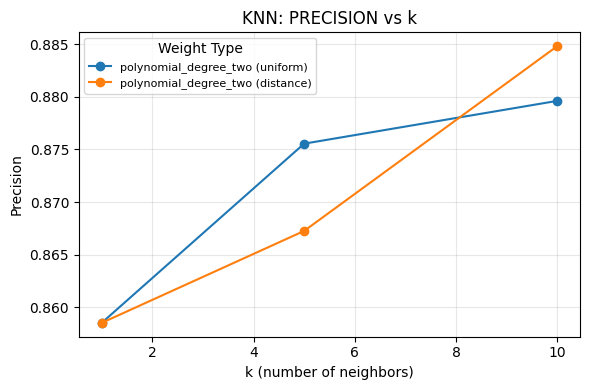

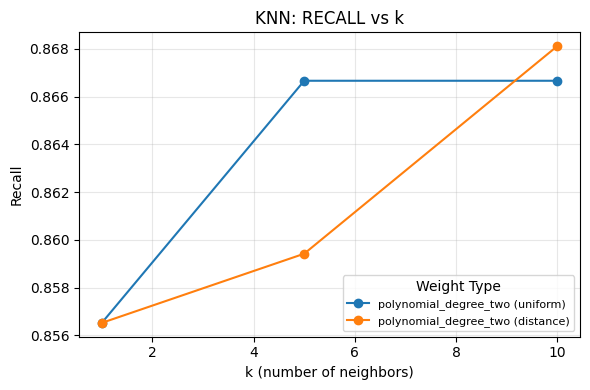

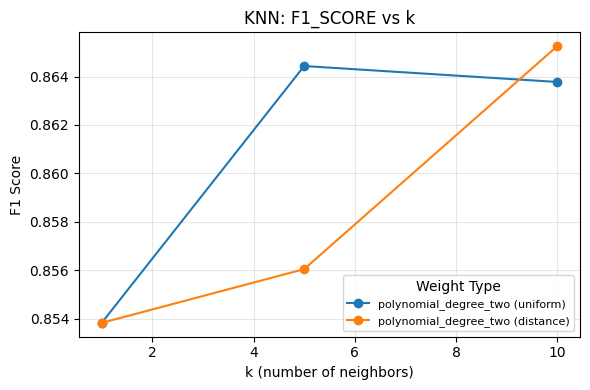

,transformation,weights,k,train_accuracy,val_accuracy,val_precision,val_recall,val_f1_score
6,polynomial_degree_two,uniform,1,1.000000,0.856522,0.858500,0.856522,0.853823
7,polynomial_degree_two,uniform,5,0.916770,0.866667,0.875551,0.866667,0.864432
8,polynomial_degree_two,uniform,10,0.892857,0.866667,0.879621,0.866667,0.863775
9,polynomial_degree_two,distance,1,1.000000,0.856522,0.858500,0.856522,0.853823
10,polynomial_degree_two,distance,5,1.000000,0.859420,0.867249,0.859420,0.856044
11,polynomial_degree_two,distance,10,1.000000,0.868116,0.884826,0.868116,0.865253


In [33]:
for w in weights:
    for k in k_values:
        model = KNeighborsClassifier(
            n_neighbors = k,
            weights = w,
        )

        model.fit(X_train_poly_degree_two, y_train)
        y_train_pred = model.predict(X_train_poly_degree_two)
        y_val_pred = model.predict(X_val_poly_degree_two)
        

        train_acc = accuracy_score(y_train, y_train_pred)
        val_acc = accuracy_score(y_val, y_val_pred)
        val_prec = precision_score(y_val, y_val_pred, average = "macro", zero_division = 0)
        val_rec = recall_score(y_val, y_val_pred, average = "macro", zero_division = 0)
        val_f1 = f1_score(y_val, y_val_pred, average = "macro", zero_division = 0)
        
        knn_results.append({
            "transformation": "polynomial_degree_two",
            "weights": w,
            "k": k,
            "train_accuracy": train_acc,
            "val_accuracy": val_acc,
            "val_precision": val_prec,
            "val_recall": val_rec,
            "val_f1_score": val_f1,
        })

knn_df = pd.DataFrame(knn_results)
knn_degree_two_df = knn_df[knn_df["transformation"] == "polynomial_degree_two"].copy()
plot_knn_metric_vs_k(knn_degree_two_df, "val_accuracy", "polynomial_degree_two")
plot_knn_metric_vs_k(knn_degree_two_df, "val_precision", "polynomial_degree_two")
plot_knn_metric_vs_k(knn_degree_two_df, "val_recall", "polynomial_degree_two")
plot_knn_metric_vs_k(knn_degree_two_df, "val_f1_score", "polynomial_degree_two")
knn_degree_two_df

### Feature Transformaion: Polynomial Degree-3 with Hyperparameter Tuning

In this section, I train a KNN model with polynomial degree 3 feature transformation and varying k values with uniform and distance weight types, seeing how each hyperparameter tuning affects validation metrics.

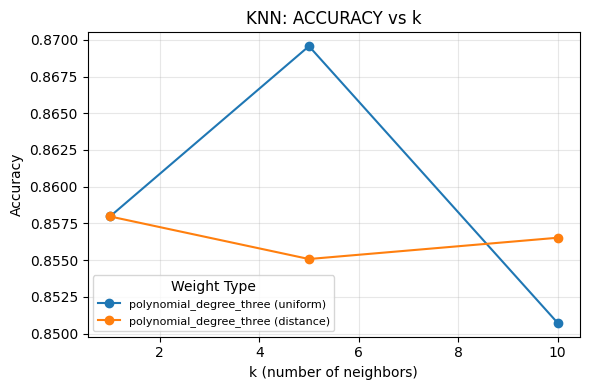

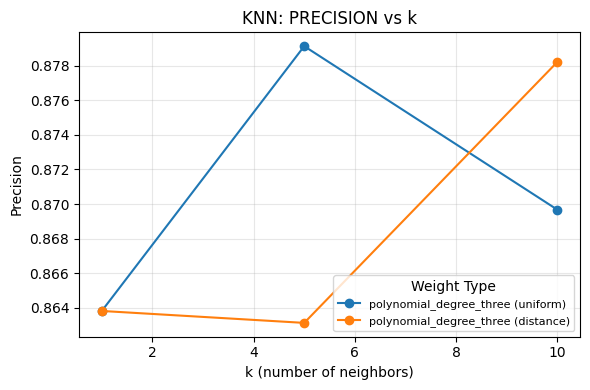

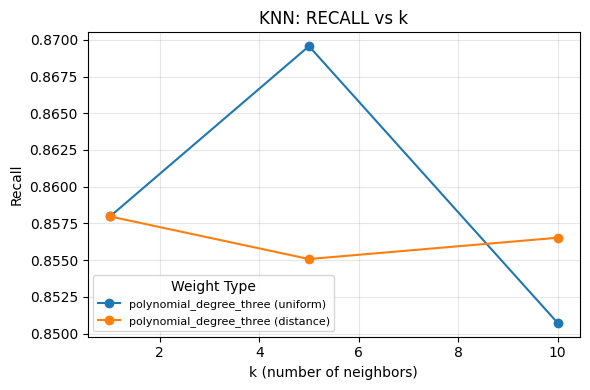

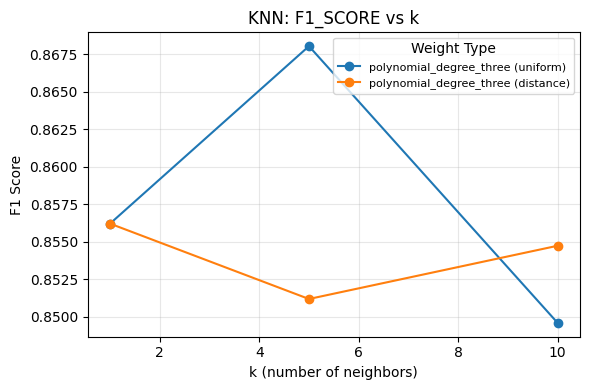

,transformation,weights,k,train_accuracy,val_accuracy,val_precision,val_recall,val_f1_score
12,polynomial_degree_three,uniform,1,1.000000,0.857971,0.863809,0.857971,0.856219
13,polynomial_degree_three,uniform,5,0.909938,0.869565,0.879138,0.869565,0.868049
14,polynomial_degree_three,uniform,10,0.882298,0.850725,0.869675,0.850725,0.849602
15,polynomial_degree_three,distance,1,1.000000,0.857971,0.863809,0.857971,0.856219
16,polynomial_degree_three,distance,5,1.000000,0.855072,0.863118,0.855072,0.851195
17,polynomial_degree_three,distance,10,1.000000,0.856522,0.878217,0.856522,0.854744


In [34]:
for w in weights:
    for k in k_values:
        model = KNeighborsClassifier(
            n_neighbors = k,
            weights = w,
        )

        model.fit(X_train_poly_degree_three, y_train)
        y_train_pred = model.predict(X_train_poly_degree_three)
        y_val_pred = model.predict(X_val_poly_degree_three)
        

        train_acc = accuracy_score(y_train, y_train_pred)
        val_acc = accuracy_score(y_val, y_val_pred)
        val_prec = precision_score(y_val, y_val_pred, average = "macro", zero_division = 0)
        val_rec = recall_score(y_val, y_val_pred, average = "macro", zero_division = 0)
        val_f1 = f1_score(y_val, y_val_pred, average = "macro", zero_division = 0)
        
        knn_results.append({
            "transformation": "polynomial_degree_three",
            "weights": w,
            "k": k,
            "train_accuracy": train_acc,
            "val_accuracy": val_acc,
            "val_precision": val_prec,
            "val_recall": val_rec,
            "val_f1_score": val_f1,
        })

knn_df = pd.DataFrame(knn_results)
knn_degree_three_df = knn_df[knn_df["transformation"] == "polynomial_degree_three"].copy()
plot_knn_metric_vs_k(knn_degree_three_df, "val_accuracy", "polynomial_degree_three")
plot_knn_metric_vs_k(knn_degree_three_df, "val_precision", "polynomial_degree_three")
plot_knn_metric_vs_k(knn_degree_three_df, "val_recall", "polynomial_degree_three")
plot_knn_metric_vs_k(knn_degree_three_df, "val_f1_score", "polynomial_degree_three")
knn_degree_three_df

### Feature Transformaion: K-Means Clusters with Hyperparameter Tuning

In this section, I train a KNN model with k-means clusters feature transformation and varying k values with uniform and distance weight types, seeing how each hyperparameter tuning affects validation metrics.

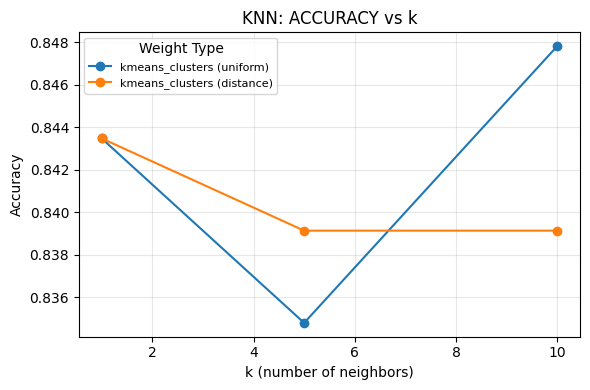

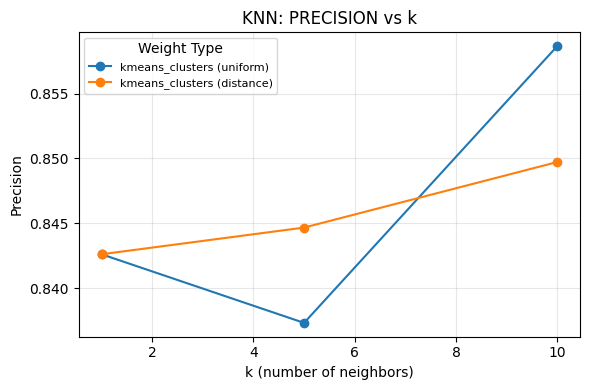

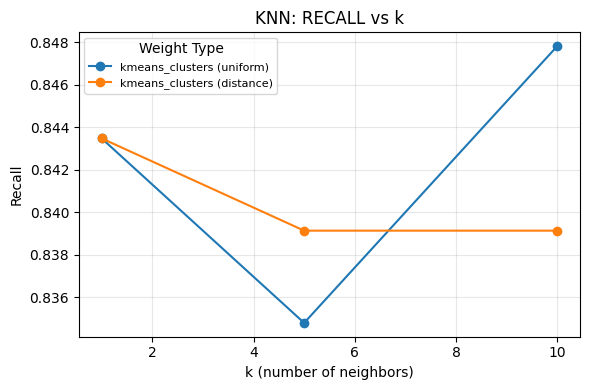

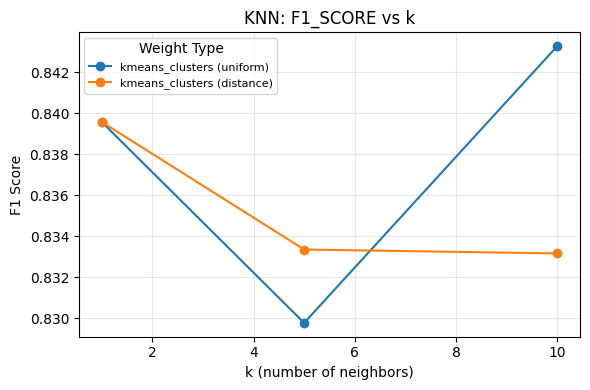

,transformation,weights,k,train_accuracy,val_accuracy,val_precision,val_recall,val_f1_score
18,kmeans_clusters,uniform,1,1.000000,0.843478,0.842618,0.843478,0.839580
19,kmeans_clusters,uniform,5,0.903416,0.834783,0.837330,0.834783,0.829771
20,kmeans_clusters,uniform,10,0.871739,0.847826,0.858652,0.847826,0.843278
21,kmeans_clusters,distance,1,1.000000,0.843478,0.842618,0.843478,0.839580
22,kmeans_clusters,distance,5,1.000000,0.839130,0.844673,0.839130,0.833352
23,kmeans_clusters,distance,10,1.000000,0.839130,0.849723,0.839130,0.833162


In [35]:
for w in weights:
    for k in k_values:
        model = KNeighborsClassifier(
            n_neighbors = k,
            weights = w,
        )

        model.fit(X_train_kmeans, y_train)
        y_train_pred = model.predict(X_train_kmeans)
        y_val_pred = model.predict(X_val_kmeans)
        

        train_acc = accuracy_score(y_train, y_train_pred)
        val_acc = accuracy_score(y_val, y_val_pred)
        val_prec = precision_score(y_val, y_val_pred, average = "macro", zero_division = 0)
        val_rec = recall_score(y_val, y_val_pred, average = "macro", zero_division = 0)
        val_f1 = f1_score(y_val, y_val_pred, average = "macro", zero_division = 0)
        
        knn_results.append({
            "transformation": "kmeans_clusters",
            "weights": w,
            "k": k,
            "train_accuracy": train_acc,
            "val_accuracy": val_acc,
            "val_precision": val_prec,
            "val_recall": val_rec,
            "val_f1_score": val_f1,
        })

knn_df = pd.DataFrame(knn_results)
knn_kmeans_clusters_df = knn_df[knn_df["transformation"] == "kmeans_clusters"].copy()
plot_knn_metric_vs_k(knn_kmeans_clusters_df, "val_accuracy", "kmeans_clusters")
plot_knn_metric_vs_k(knn_kmeans_clusters_df, "val_precision", "kmeans_clusters")
plot_knn_metric_vs_k(knn_kmeans_clusters_df, "val_recall", "kmeans_clusters")
plot_knn_metric_vs_k(knn_kmeans_clusters_df, "val_f1_score", "kmeans_clusters")
knn_kmeans_clusters_df

## NEURAL NETWORKS
### Baseline NN

In this section, I run the baseline NN model with one hidden layer with 64 neurons to find the starting metrics for the validation set before using different activation functions and alpha values as hyperparameter tuning.

/Users/sam/Desktop/hiragana-ml-project/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


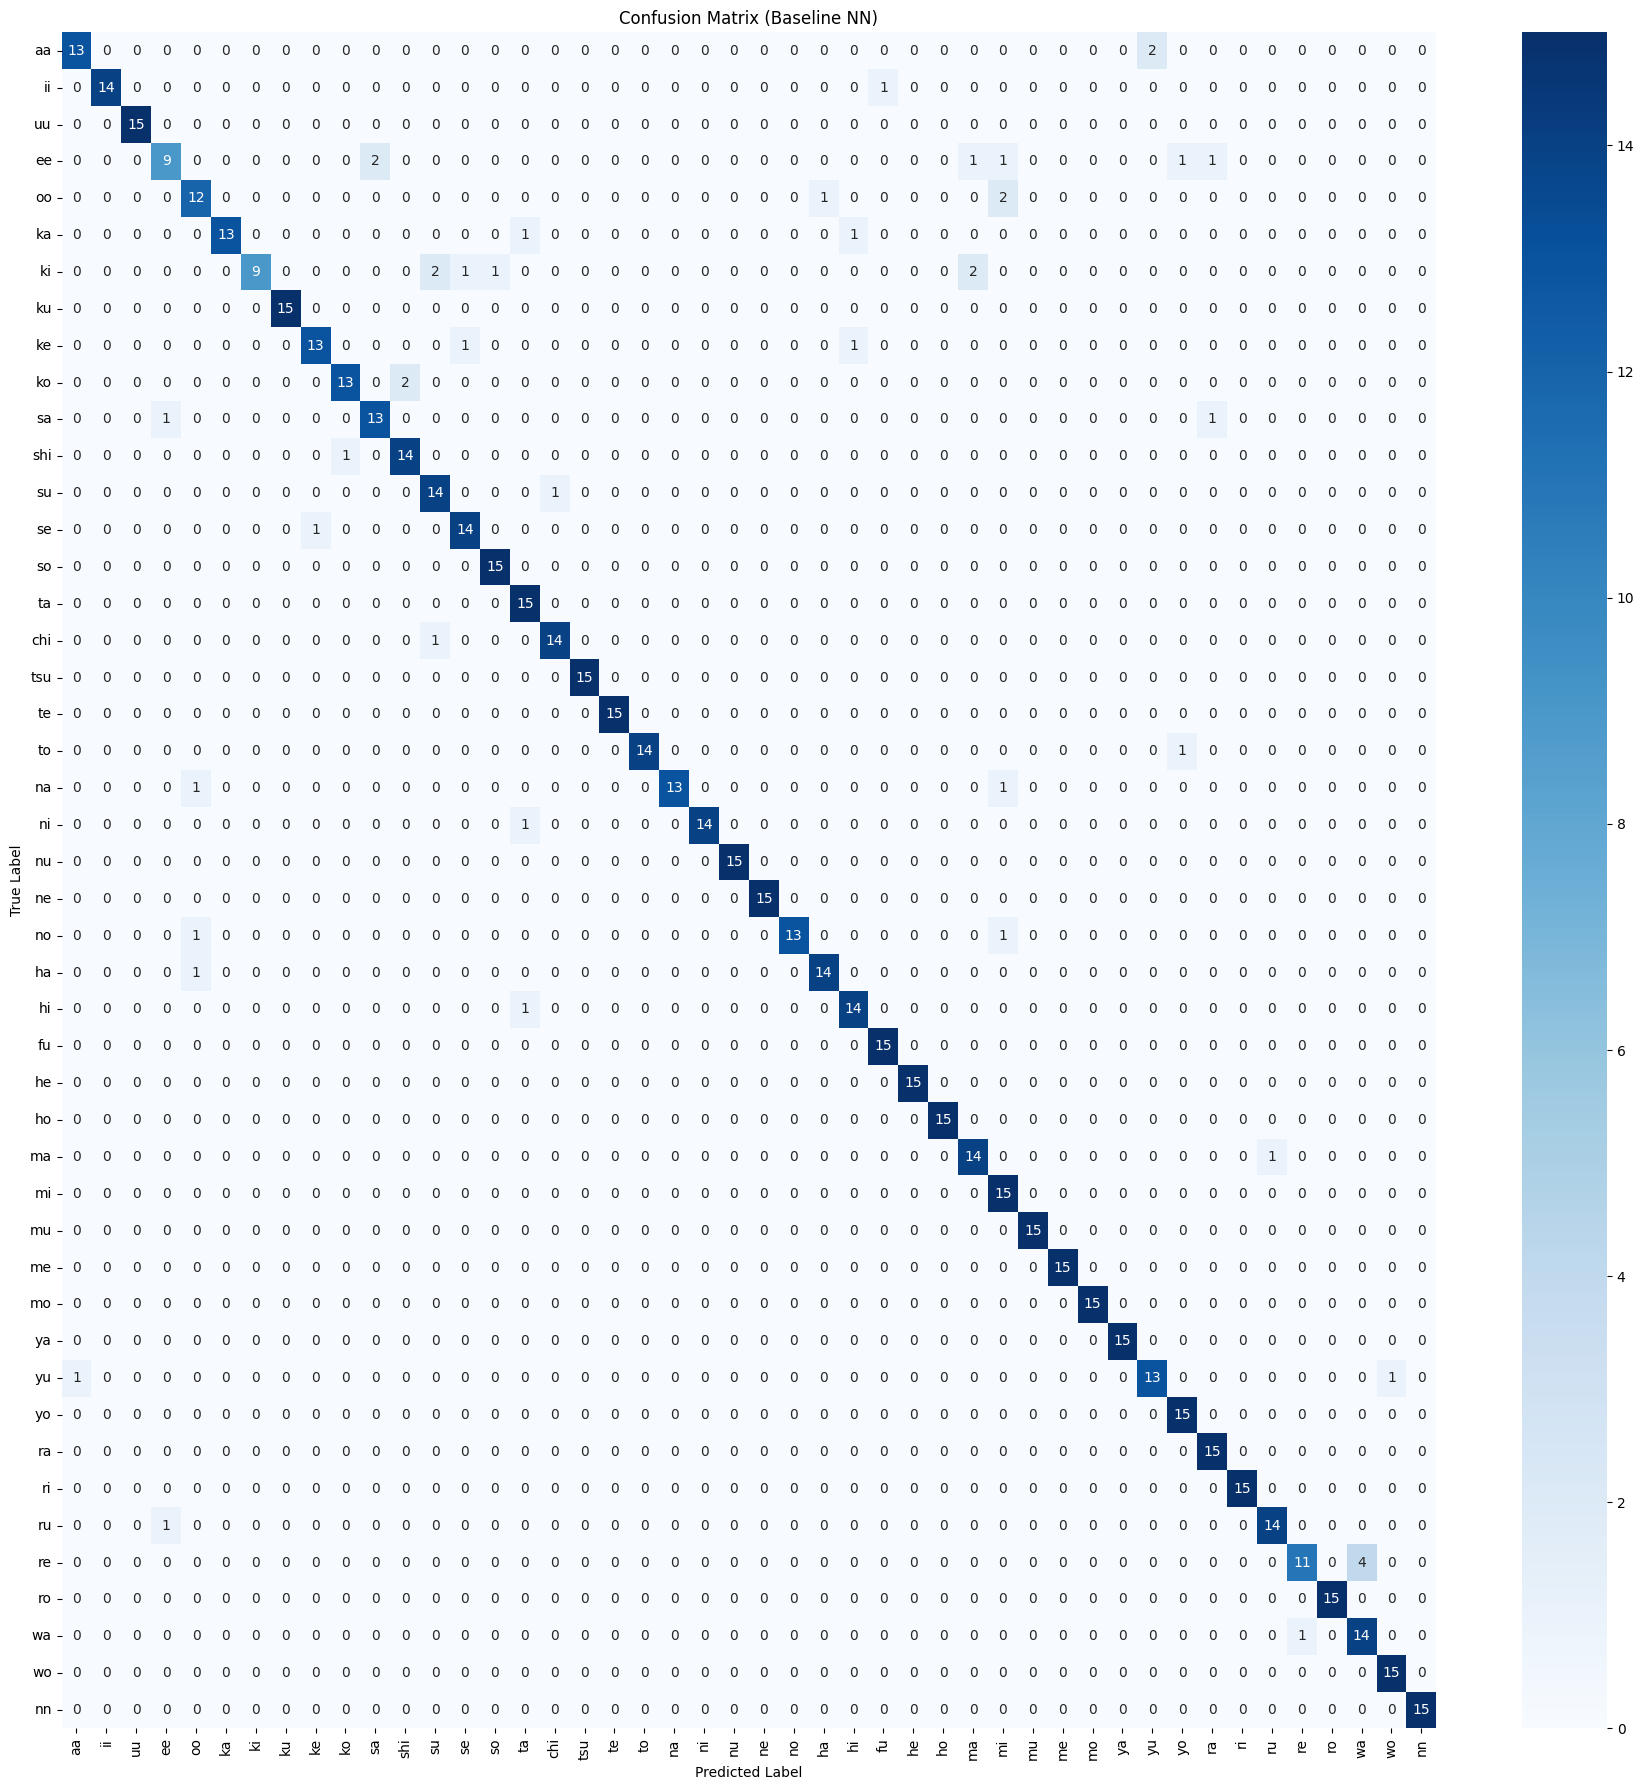

---- Baseline Performance (NN) ----
Train Accuracy: 0.9531
Validation Accuracy: 0.9319
Validation Precision: 0.9362
Validation Recall: 0.9319
Validation F1 Score: 0.9308


In [37]:
baseline_nn = MLPClassifier(
    hidden_layer_sizes = (64, ), 
    activation = "logistic",
    alpha = 0.0,
    max_iter = 500,
    random_state = 42 
)

baseline_nn.fit(X_train_scaled, y_train)

y_hat_train_baseline_nn = baseline_nn.predict(X_train_scaled)
y_hat_val_baseline_nn = baseline_nn.predict(X_val_scaled)

baseline_nn_train_accuracy = accuracy_score(y_train, y_hat_train_baseline_nn)
baseline_nn_val_accuracy = accuracy_score(y_val, y_hat_val_baseline_nn)
baseline_nn_val_precision = precision_score(y_val, y_hat_val_baseline_nn, average = 'macro', zero_division = 0)
baseline_nn_val_recall = recall_score(y_val, y_hat_val_baseline_nn, average = 'macro', zero_division = 0)
baseline_nn_val_f1 = f1_score(y_val, y_hat_val_baseline_nn, average = 'macro', zero_division = 0)
baseline_nn_val_cm = confusion_matrix(y_val, y_hat_val_baseline_nn)

plt.figure(figsize = (18, 18))
sns.heatmap(
    baseline_nn_val_cm,
    annot = True,
    cmap = "Blues",
    xticklabels = PHONETIC_LABELS,
    yticklabels = PHONETIC_LABELS
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Baseline NN)")
plt.xticks(rotation = 90, fontsize = 10)
plt.yticks(rotation = 0, fontsize = 10)
plt.tight_layout()
plt.show()

print("---- Baseline Performance (NN) ----")
print(f"Train Accuracy: {baseline_nn_train_accuracy:.4f}")
print(f"Validation Accuracy: {baseline_nn_val_accuracy:.4f}")
print(f"Validation Precision: {baseline_nn_val_precision:.4f}")
print(f"Validation Recall: {baseline_nn_val_recall:.4f}")
print(f"Validation F1 Score: {baseline_nn_val_f1:.4f}")

### One Hidden Layer

In this section, I train a NN model with one hidden layer of 64 neurons, and varying activation functions and alpha values, seeing how each hyperparameter tuning affects validation metrics.

In [38]:
def plot_nn_metric_vs_alphas(df, metric, transformation_name):
    subset = df[df["transformation"] == transformation_name].copy()
    activations = sorted(subset["activation"].unique())
    
    plt.figure(figsize = (6, 4))

    for act in activations:
        sub_act = subset[subset["activation"] == act].copy()
        sub_act = sub_act.sort_values(by = "alpha")

        alphas = sub_act["alpha"].values
        ys = sub_act[metric].values
        
        plt.plot(
            alphas,
            ys,
            marker = "o",
            label = act
        )

    plt.xscale("log")
    plt.xlabel("Alpha (L2 Regularization, log scale)")
    plt.ylabel(metric.replace("val_", "").replace("_", " ").title())
    plt.title(f"NN ({transformation_name}): {metric.replace('val_', '').upper()} vs Alpha")
    plt.grid(True, alpha = 0.3)
    plt.legend(title="Activation", fontsize = 8)
    plt.tight_layout()
    plt.show()

In [41]:
nn_results = []
activations = ["relu", "tanh", "logistic"]
alpha_values = [0.000001, 0.0001, 0.001, 0.01, 0.1, 1.0]

/Users/sam/Desktop/hiragana-ml-project/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sam/Desktop/hiragana-ml-project/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sam/Desktop/hiragana-ml-project/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sam/Desktop/hiragana-ml-project/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the 

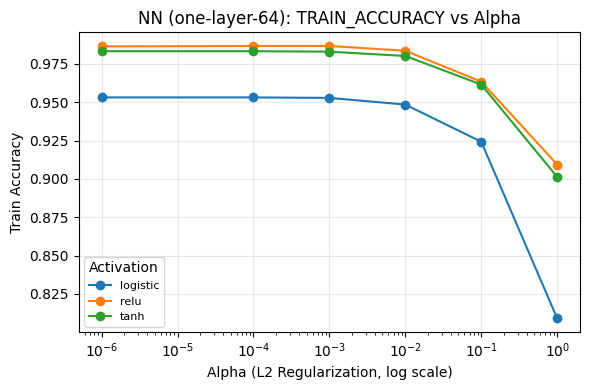

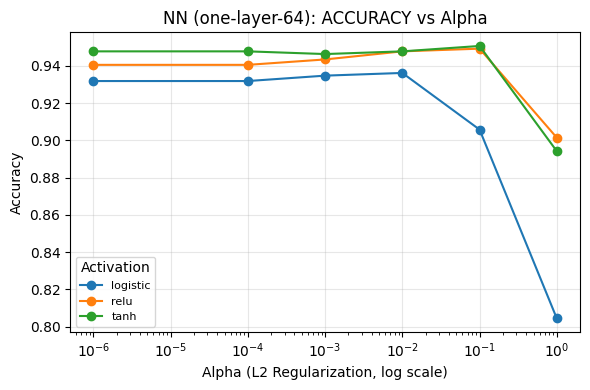

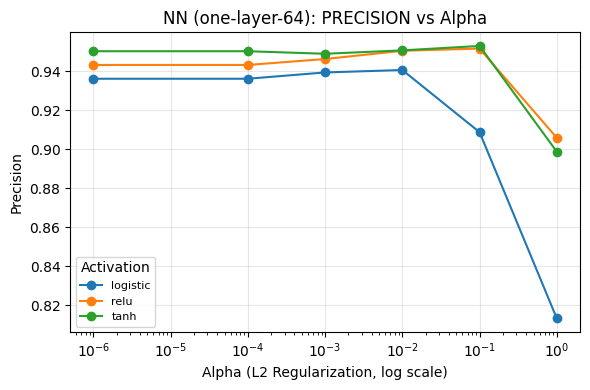

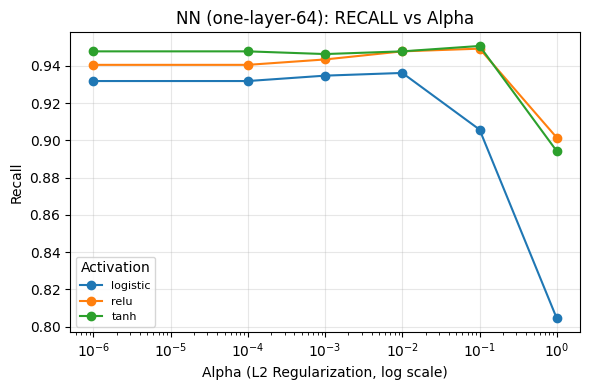

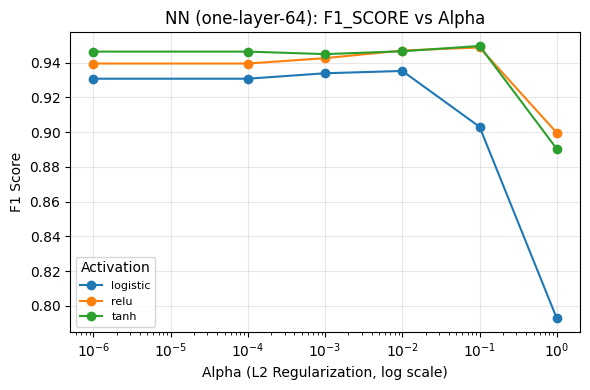

,transformation,activation,alpha,train_accuracy,val_accuracy,val_precision,val_recall,val_f1_score
0,one-layer-64,relu,0.000001,0.986335,0.940580,0.943247,0.940580,0.939496
1,one-layer-64,relu,0.000100,0.986646,0.940580,0.943247,0.940580,0.939496
2,one-layer-64,relu,0.001000,0.986646,0.943478,0.946291,0.943478,0.942598
3,one-layer-64,relu,0.010000,0.983540,0.947826,0.950522,0.947826,0.946991
4,one-layer-64,relu,0.100000,0.963354,0.949275,0.951652,0.949275,0.948739
5,one-layer-64,relu,1.000000,0.909317,0.901449,0.905869,0.901449,0.899623
6,one-layer-64,tanh,0.000001,0.983230,0.947826,0.950292,0.947826,0.946372
7,one-layer-64,tanh,0.000100,0.983230,0.947826,0.950292,0.947826,0.946372
8,one-layer-64,tanh,0.001000,0.982919,0.946377,0.948989,0.946377,0.944915
9,one-layer-64,tanh,0.010000,0.980124,0.947826,0.950732,0.947826,0.946561


In [42]:
for act in activations:
    for alpha in alpha_values:

        nn = MLPClassifier(
            hidden_layer_sizes = (64, ), 
            activation = act,
            alpha = alpha,
            max_iter = 500,
            random_state = 42
        )

        nn.fit(X_train_scaled, y_train)
        y_train_pred = nn.predict(X_train_scaled)
        y_val_pred = nn.predict(X_val_scaled)

        train_acc = accuracy_score(y_train, y_train_pred)
        val_acc = accuracy_score(y_val, y_val_pred)
        val_prec = precision_score(y_val, y_val_pred, average = "macro", zero_division = 0)
        val_rec = recall_score(y_val, y_val_pred, average = "macro", zero_division = 0)
        val_f1 = f1_score(y_val, y_val_pred, average = "macro", zero_division = 0)

        nn_results.append({
            "transformation": "one-layer-64",
            "activation": act,
            "alpha": alpha,
            "train_accuracy": train_acc,
            "val_accuracy": val_acc,
            "val_precision": val_prec,
            "val_recall": val_rec,
            "val_f1_score": val_f1,
        })

nn_df = pd.DataFrame(nn_results)
plot_nn_metric_vs_alphas(nn_df, "train_accuracy", "one-layer-64")
plot_nn_metric_vs_alphas(nn_df, "val_accuracy", "one-layer-64")
plot_nn_metric_vs_alphas(nn_df, "val_precision", "one-layer-64")
plot_nn_metric_vs_alphas(nn_df, "val_recall", "one-layer-64")
plot_nn_metric_vs_alphas(nn_df, "val_f1_score", "one-layer-64")
nn_df

### Two Hidden Layers

In this section, I train a NN model with two hidden layer of 64 neurons and 32 neurons, and varying activation functions and alpha values, seeing how each hyperparameter tuning affects validation metrics.

/Users/sam/Desktop/hiragana-ml-project/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sam/Desktop/hiragana-ml-project/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sam/Desktop/hiragana-ml-project/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sam/Desktop/hiragana-ml-project/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the 

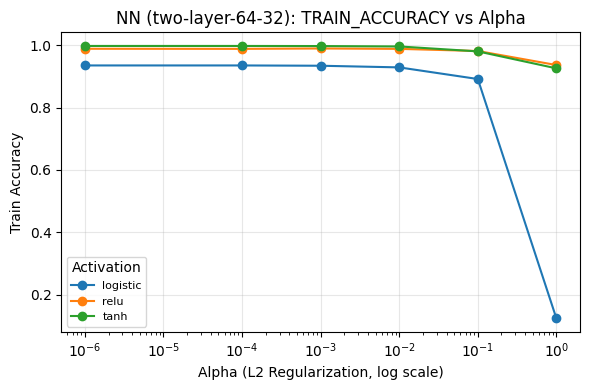

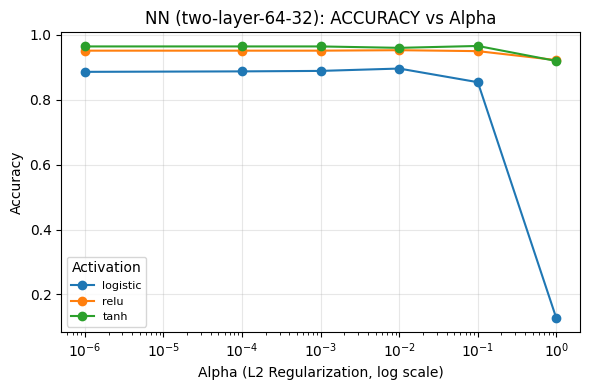

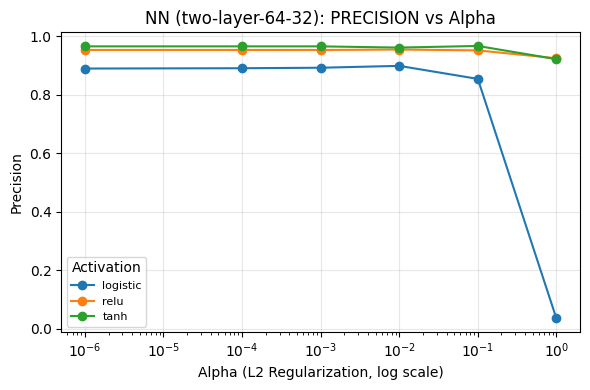

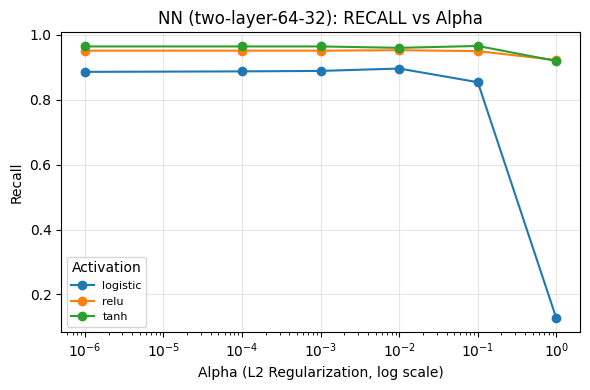

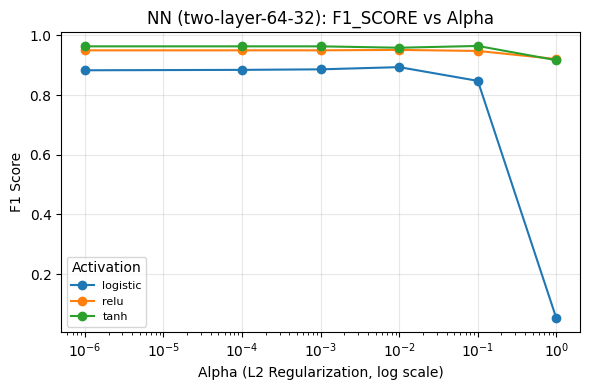

,transformation,activation,alpha,train_accuracy,val_accuracy,val_precision,val_recall,val_f1_score
18,two-layer-64-32,relu,0.000001,0.988199,0.950725,0.952962,0.950725,0.949960
19,two-layer-64-32,relu,0.000100,0.987888,0.950725,0.952962,0.950725,0.949960
20,two-layer-64-32,relu,0.001000,0.989130,0.950725,0.952760,0.950725,0.950036
21,two-layer-64-32,relu,0.010000,0.987888,0.952174,0.954334,0.952174,0.951414
22,two-layer-64-32,relu,0.100000,0.981056,0.949275,0.951446,0.949275,0.947964
23,two-layer-64-32,relu,1.000000,0.936025,0.921739,0.924480,0.921739,0.920815
24,two-layer-64-32,tanh,0.000001,0.997205,0.963768,0.965171,0.963768,0.963362
25,two-layer-64-32,tanh,0.000100,0.997205,0.963768,0.965171,0.963768,0.963362
26,two-layer-64-32,tanh,0.001000,0.996894,0.963768,0.965171,0.963768,0.963362
27,two-layer-64-32,tanh,0.010000,0.995652,0.959420,0.961034,0.959420,0.958744


In [43]:
for act in activations:
    for alpha in alpha_values:

        nn = MLPClassifier(
            hidden_layer_sizes = (64, 32, ), 
            activation = act,
            alpha = alpha,
            max_iter = 500,
            random_state = 42
        )

        nn.fit(X_train_scaled, y_train)
        y_train_pred = nn.predict(X_train_scaled)
        y_val_pred   = nn.predict(X_val_scaled)

        train_acc = accuracy_score(y_train, y_train_pred)
        val_acc   = accuracy_score(y_val, y_val_pred)
        val_prec  = precision_score(y_val, y_val_pred, average = "macro", zero_division = 0)
        val_rec   = recall_score(y_val, y_val_pred, average = "macro", zero_division = 0)
        val_f1    = f1_score(y_val, y_val_pred, average = "macro", zero_division = 0)

        nn_results.append({
            "transformation": "two-layer-64-32",
            "activation": act,
            "alpha": alpha,
            "train_accuracy": train_acc,
            "val_accuracy": val_acc,
            "val_precision": val_prec,
            "val_recall": val_rec,
            "val_f1_score": val_f1,
        })

nn_df = pd.DataFrame(nn_results)
nn_two_layer_df = nn_df[nn_df["transformation"] == "two-layer-64-32"].copy()
plot_nn_metric_vs_alphas(nn_two_layer_df, "train_accuracy", "two-layer-64-32")
plot_nn_metric_vs_alphas(nn_two_layer_df, "val_accuracy", "two-layer-64-32")
plot_nn_metric_vs_alphas(nn_two_layer_df, "val_precision", "two-layer-64-32")
plot_nn_metric_vs_alphas(nn_two_layer_df, "val_recall", "two-layer-64-32")
plot_nn_metric_vs_alphas(nn_two_layer_df, "val_f1_score", "two-layer-64-32")
nn_two_layer_df

### Three Hidden Layers

In this section, I train a NN model with three hidden layer of 64 neurons, 64 neurons, and 32 neurons, and varying activation functions and alpha values, seeing how each hyperparameter tuning affects validation metrics.

/Users/sam/Desktop/hiragana-ml-project/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sam/Desktop/hiragana-ml-project/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sam/Desktop/hiragana-ml-project/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sam/Desktop/hiragana-ml-project/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the 

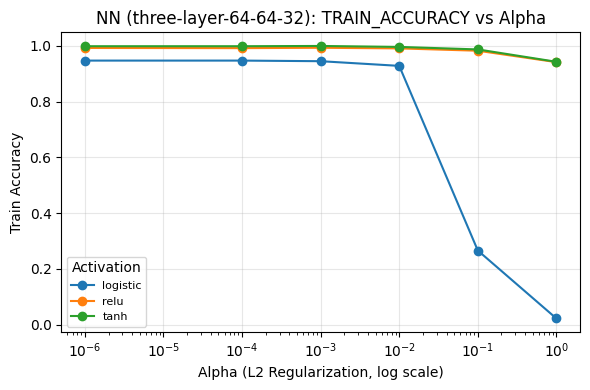

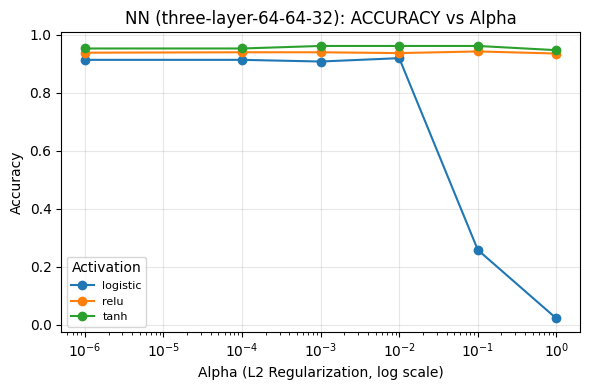

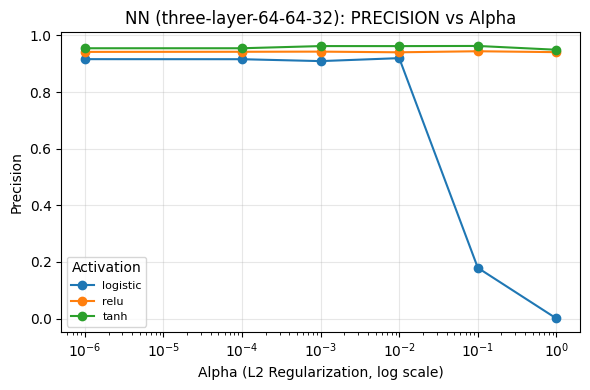

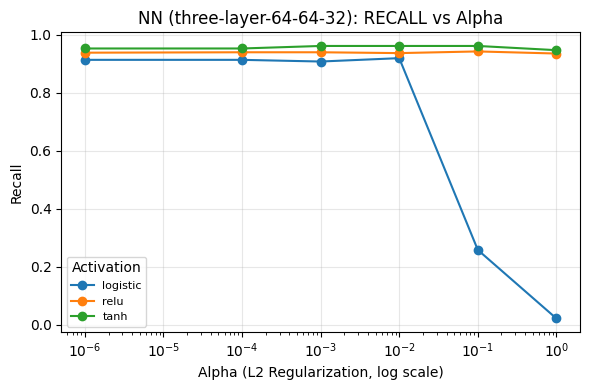

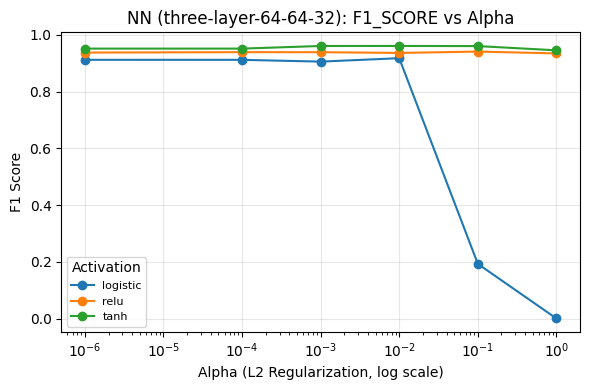

,transformation,activation,alpha,train_accuracy,val_accuracy,val_precision,val_recall,val_f1_score
36,three-layer-64-64-32,relu,0.000001,0.992236,0.937681,0.941793,0.937681,0.937327
37,three-layer-64-64-32,relu,0.000100,0.991615,0.939130,0.942214,0.939130,0.938739
38,three-layer-64-64-32,relu,0.001000,0.992857,0.939130,0.942748,0.939130,0.938630
39,three-layer-64-64-32,relu,0.010000,0.990683,0.936232,0.940376,0.936232,0.936010
40,three-layer-64-64-32,relu,0.100000,0.982298,0.942029,0.944086,0.942029,0.940806
41,three-layer-64-64-32,relu,1.000000,0.941304,0.934783,0.940878,0.934783,0.934294
42,three-layer-64-64-32,tanh,0.000001,0.998447,0.952174,0.954650,0.952174,0.951269
43,three-layer-64-64-32,tanh,0.000100,0.998447,0.952174,0.954650,0.952174,0.951269
44,three-layer-64-64-32,tanh,0.001000,0.999379,0.960870,0.962336,0.960870,0.960466
45,three-layer-64-64-32,tanh,0.010000,0.995963,0.960870,0.962235,0.960870,0.960567


In [44]:
for act in activations:
    for alpha in alpha_values:

        nn = MLPClassifier(
            hidden_layer_sizes = (64, 64, 32, ), 
            activation = act,
            alpha = alpha,
            max_iter = 500,
            random_state = 42
        )

        nn.fit(X_train_scaled, y_train)
        y_train_pred = nn.predict(X_train_scaled)
        y_val_pred   = nn.predict(X_val_scaled)

        train_acc = accuracy_score(y_train, y_train_pred)
        val_acc   = accuracy_score(y_val, y_val_pred)
        val_prec  = precision_score(y_val, y_val_pred, average = "macro", zero_division = 0)
        val_rec   = recall_score(y_val, y_val_pred, average = "macro", zero_division = 0)
        val_f1    = f1_score(y_val, y_val_pred, average = "macro", zero_division = 0)

        nn_results.append({
            "transformation": "three-layer-64-64-32",
            "activation": act,
            "alpha": alpha,
            "train_accuracy": train_acc,
            "val_accuracy": val_acc,
            "val_precision": val_prec,
            "val_recall": val_rec,
            "val_f1_score": val_f1,
        })

nn_df = pd.DataFrame(nn_results)
nn_three_layer_df = nn_df[nn_df["transformation"] == "three-layer-64-64-32"].copy()
plot_nn_metric_vs_alphas(nn_three_layer_df, "train_accuracy", "three-layer-64-64-32")
plot_nn_metric_vs_alphas(nn_three_layer_df, "val_accuracy", "three-layer-64-64-32")
plot_nn_metric_vs_alphas(nn_three_layer_df, "val_precision", "three-layer-64-64-32")
plot_nn_metric_vs_alphas(nn_three_layer_df, "val_recall", "three-layer-64-64-32")
plot_nn_metric_vs_alphas(nn_three_layer_df, "val_f1_score", "three-layer-64-64-32")
nn_three_layer_df

### Wider Two Hidden Layers

In this section, I train a NN model with two hidden layer of 128 neurons and 64 neurons, and varying activation functions and alpha values, seeing how each hyperparameter tuning affects validation metrics.

/Users/sam/Desktop/hiragana-ml-project/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sam/Desktop/hiragana-ml-project/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sam/Desktop/hiragana-ml-project/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sam/Desktop/hiragana-ml-project/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the 

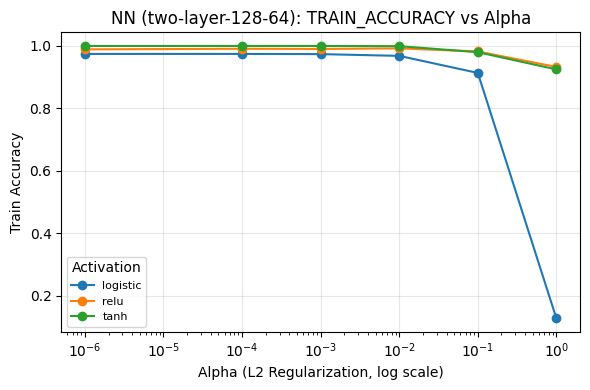

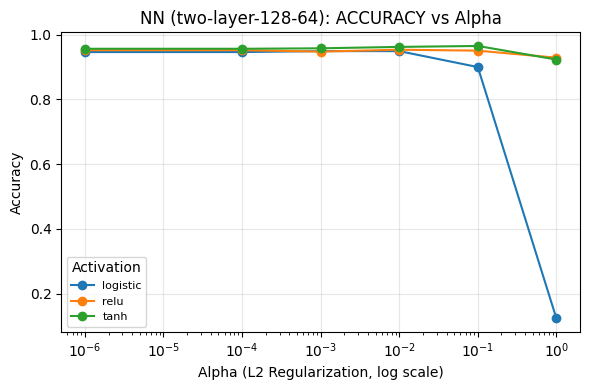

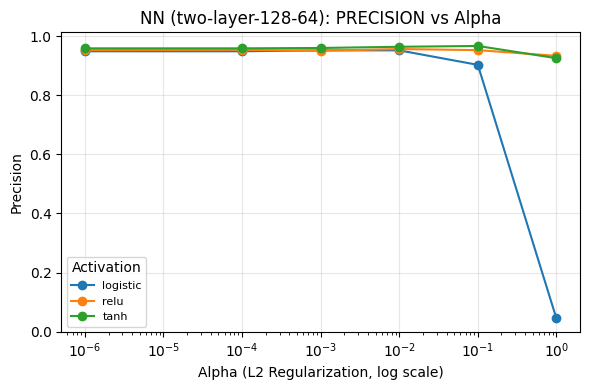

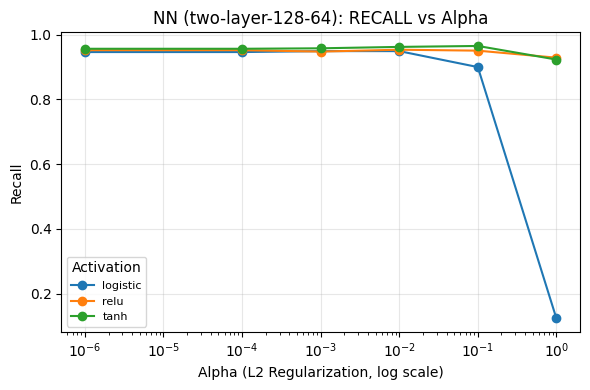

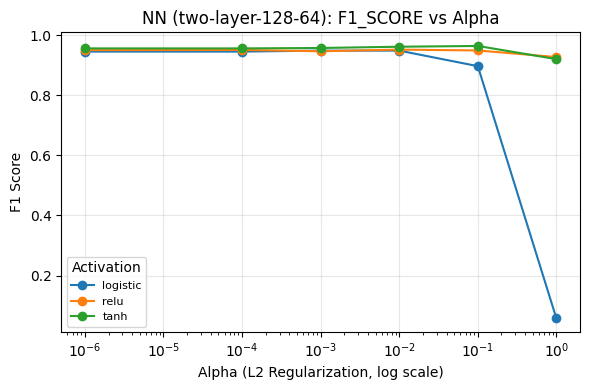

,transformation,activation,alpha,train_accuracy,val_accuracy,val_precision,val_recall,val_f1_score
54,two-layer-128-64,relu,0.000001,0.989130,0.952174,0.953045,0.952174,0.950551
55,two-layer-128-64,relu,0.000100,0.990994,0.952174,0.954040,0.952174,0.951288
56,two-layer-128-64,relu,0.001000,0.990373,0.947826,0.950667,0.947826,0.946830
57,two-layer-128-64,relu,0.010000,0.992236,0.953623,0.956711,0.953623,0.952337
58,two-layer-128-64,relu,0.100000,0.982298,0.950725,0.952892,0.950725,0.949519
59,two-layer-128-64,relu,1.000000,0.932919,0.928986,0.933577,0.928986,0.927559
60,two-layer-128-64,tanh,0.000001,1.000000,0.956522,0.958973,0.956522,0.956384
61,two-layer-128-64,tanh,0.000100,1.000000,0.956522,0.958973,0.956522,0.956384
62,two-layer-128-64,tanh,0.001000,1.000000,0.957971,0.960198,0.957971,0.957746
63,two-layer-128-64,tanh,0.010000,0.999379,0.962319,0.964295,0.962319,0.961967


In [45]:
for act in activations:
    for alpha in alpha_values:

        nn = MLPClassifier(
            hidden_layer_sizes = (128, 64, ), 
            activation = act,
            alpha = alpha,
            max_iter = 500,
            random_state = 42
        )

        nn.fit(X_train_scaled, y_train)
        y_train_pred = nn.predict(X_train_scaled)
        y_val_pred   = nn.predict(X_val_scaled)

        train_acc = accuracy_score(y_train, y_train_pred)
        val_acc   = accuracy_score(y_val, y_val_pred)
        val_prec  = precision_score(y_val, y_val_pred, average = "macro", zero_division = 0)
        val_rec   = recall_score(y_val, y_val_pred, average = "macro", zero_division = 0)
        val_f1    = f1_score(y_val, y_val_pred, average = "macro", zero_division = 0)

        nn_results.append({
            "transformation": "two-layer-128-64",
            "activation": act,
            "alpha": alpha,
            "train_accuracy": train_acc,
            "val_accuracy": val_acc,
            "val_precision": val_prec,
            "val_recall": val_rec,
            "val_f1_score": val_f1,
        })

nn_df = pd.DataFrame(nn_results)
nn_wide_two_layer_df = nn_df[nn_df["transformation"] == "two-layer-128-64"].copy()
plot_nn_metric_vs_alphas(nn_wide_two_layer_df, "train_accuracy", "two-layer-128-64")
plot_nn_metric_vs_alphas(nn_wide_two_layer_df, "val_accuracy", "two-layer-128-64")
plot_nn_metric_vs_alphas(nn_wide_two_layer_df, "val_precision", "two-layer-128-64")
plot_nn_metric_vs_alphas(nn_wide_two_layer_df, "val_recall", "two-layer-128-64")
plot_nn_metric_vs_alphas(nn_wide_two_layer_df, "val_f1_score", "two-layer-128-64")
nn_wide_two_layer_df

## TEST SET
### Model Picked: Neural Network with Two Hidden Layers (64, 32), using Tanh activation function and 0.1 alpha value

In [46]:
best_nn_activation = "tanh"
best_nn_alpha = 0.1
best_nn_hidden_layers = (64, 32)

test_nn = MLPClassifier(
    hidden_layer_sizes = (best_nn_hidden_layers),
    activation = best_nn_activation,
    alpha = best_nn_alpha,
    max_iter = 500,
    random_state = 42 
)

test_nn.fit(X_train_scaled, y_train)
y_hat = test_nn.predict(X_test_scaled)

test_accuracy = accuracy_score(y_test, y_hat)
test_precision = precision_score(y_test, y_hat, average = 'macro', zero_division = 0)
test_recall = recall_score(y_test, y_hat, average = 'macro', zero_division = 0)
test_f1 = f1_score(y_test, y_hat, average = 'macro', zero_division = 0)
test_cm = confusion_matrix(y_test, y_hat)

/Users/sam/Desktop/hiragana-ml-project/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


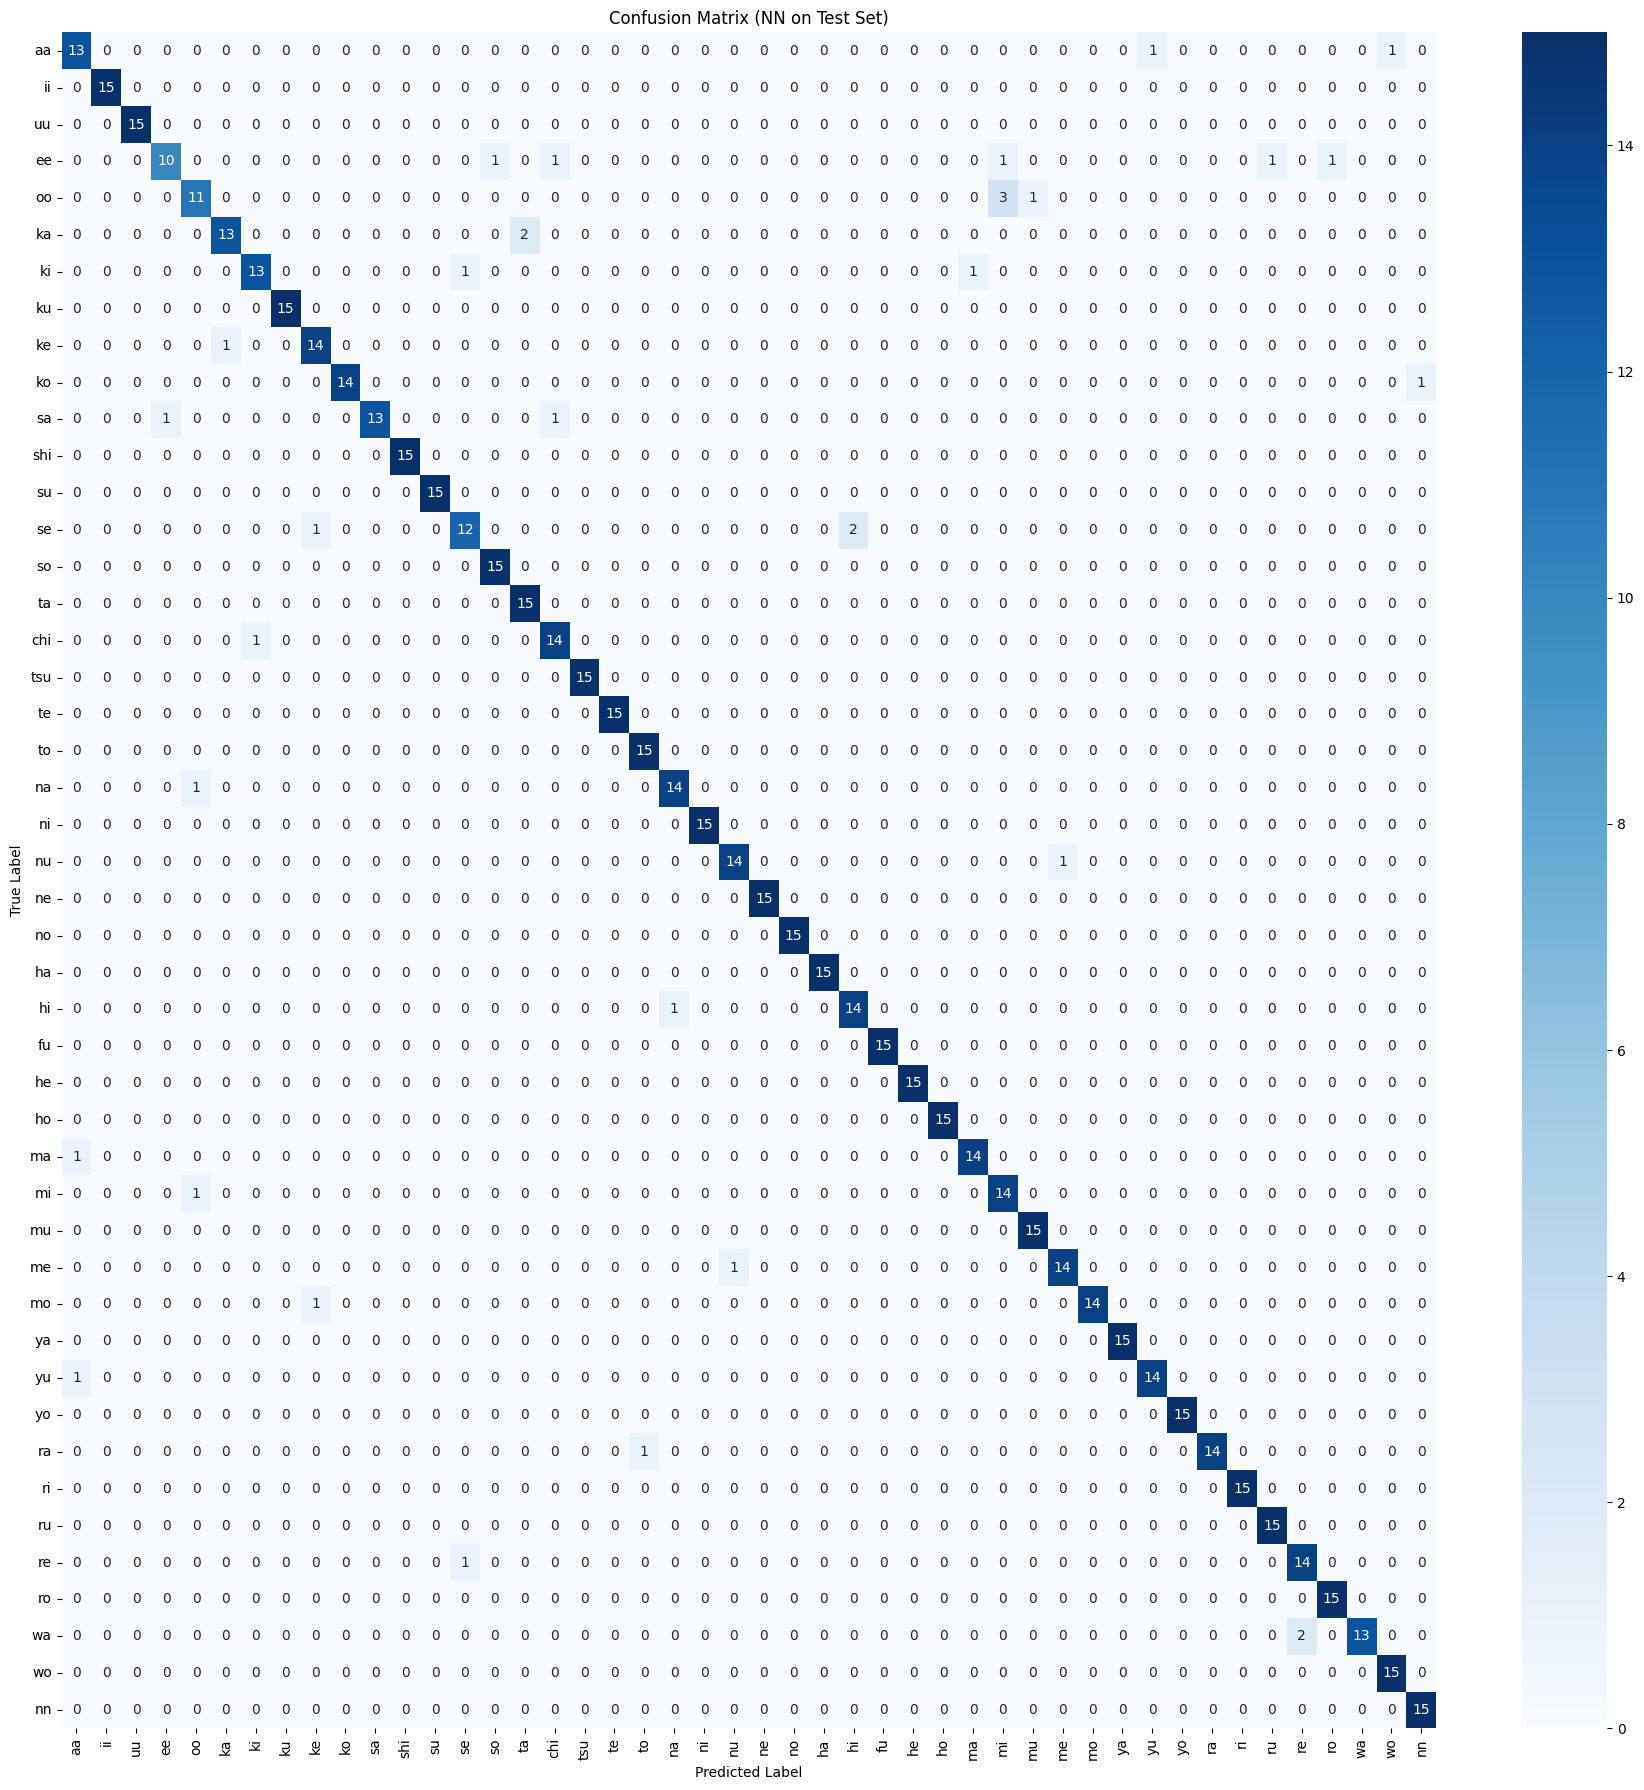

---- Test Set Performance (Neural Network: 64-32, tanh, alpha = 0.1) ----
Accuracy : 0.9493
Precision: 0.9506
Recall   : 0.9493
F1 Score : 0.9486


In [48]:
plt.figure(figsize = (18, 18))
sns.heatmap(
    test_cm,
    annot = True,
    cmap = "Blues",
    xticklabels = PHONETIC_LABELS,
    yticklabels = PHONETIC_LABELS
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (NN on Test Set)")
plt.xticks(rotation = 90, fontsize = 10)
plt.yticks(rotation = 0, fontsize = 10)
plt.tight_layout()
plt.show()


print("---- Test Set Performance (Neural Network: 64-32, tanh, alpha = 0.1) ----")
print(f"Accuracy : {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall   : {test_recall:.4f}")
print(f"F1 Score : {test_f1:.4f}")